In [1]:
%load_ext autoreload

In [2]:
%autoreload
import utilhysplit

/hysplit-users/alicec/anaconda3/envs/paris/lib/python3.8/site-packages/pyresample/bilinear/__init__.py:49: UserWarning: XArray and/or zarr not found, XArrayBilinearResampler won't be available.
  warnings.warn("XArray and/or zarr not found, XArrayBilinearResampler won't be available.")


In [3]:
import geopandas

In [4]:
from utilhysplit import parutils

In [5]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from monetio.models import hysplit

In [6]:
from utilvolc import volcat
import utilvolc.ash_inverse as ai
import utilvolc.ash_eval as ae
from utilvolc import volcMER
from utilhysplit.evaluation import ensemble_tools
from utilhysplit.evaluation import plume_stat
import cases

In [15]:
%autoreload
case = cases.runM()
print(case)
tag = case.vhash['tag']
tdir = case.vhash['tdir']
tname = case.vhash['tname']
configdir= case.vhash['configdir']
configfile = case.vhash['configfile']
vdir = case.vhash['vdir']
vid = case.vhash['vid']
gdir = case.vhash['gdir']
graphicstype = case.vhash['graphicstype']
vloc = case.vhash['vloc']

vloc : [160.587, 55.978]
tag : M
tdir : ../RunM/RunM_1_2_3_4_TF
tname : RunM4.nc
configdir : ../RunM
configfile : config.invbezyM.txt
vdir : ../data/volcat/
vid : v300250
gdir : ./graphics/
graphicstype : png



In [19]:
%autoreload
aeval = ae.AshEval(tdir,tname,vdir,vid,configdir=configdir,configfile=configfile)

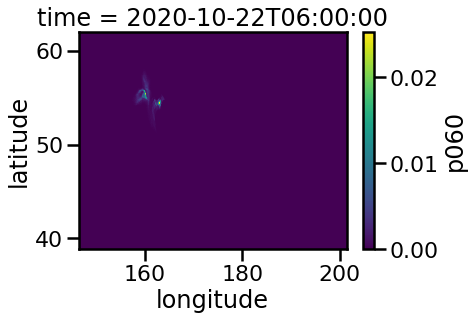

In [36]:
aeval.cdump.isel(time=10).sum(dim='ens').sum(dim='z').plot.pcolormesh(x='longitude',y='latitude')

In [30]:
%autoreload
#time list to prepare.
# start with one hour after eruption. 21:00-22:00
dlist = []
sdate = datetime.datetime(2020,10,21,23,0)
#sdate = datetime.datetime(2020,10,22,12,0)
dt = datetime.timedelta(hours=1)
for iii in np.arange(0,20):
    drange = [sdate, sdate+dt]
    dlist.append(drange)
    sdate += dt
print(dlist[0])
print(dlist[-1])

[datetime.datetime(2020, 10, 21, 23, 0), datetime.datetime(2020, 10, 22, 0, 0)]
[datetime.datetime(2020, 10, 22, 18, 0), datetime.datetime(2020, 10, 22, 19, 0)]


In [31]:
'mult' in aeval.cdump.attrs

False

In [32]:
%autoreload
# For the cylindrical source change the MER.
if 'mult' in aeval.cdump.attrs:
    xmult = aeval.cdump.mult
    print('{:2e}'.format(xmult))
    # convert unit mass using the 15000 kg/s from volcat.
    from utilvolc import volcMER
    cmult = volcMER.MER2unit(1.5e4,1)
    print('Using 15000 kg/s: unit mass =  {:2e} g/hr'.format(cmult[0]))
    cmult = cmult[0] 
    # divide by the old conversion factor and multiply by the new one.
    # Note that this does not change the cdump attribute but only affects output.
    aeval.set_concmult(cmult/xmult)
else:
    aeval.set_concmult(1)

In [44]:
aeval.set_sampling_time()

'start'

In [46]:
# time averages observations
# matches observations and model forecast to the same domain.
# these are stored in dictionaries.
%autoreload
for drange in dlist:
    print(drange)
    aeval.prepare_one_time(drange)

[datetime.datetime(2020, 10, 21, 23, 0), datetime.datetime(2020, 10, 22, 0, 0)]
HERE
[datetime.datetime(2020, 10, 22, 0, 0), datetime.datetime(2020, 10, 22, 1, 0)]
HERE
[datetime.datetime(2020, 10, 22, 1, 0), datetime.datetime(2020, 10, 22, 2, 0)]
HERE
[datetime.datetime(2020, 10, 22, 2, 0), datetime.datetime(2020, 10, 22, 3, 0)]
HERE
[datetime.datetime(2020, 10, 22, 3, 0), datetime.datetime(2020, 10, 22, 4, 0)]
HERE
[datetime.datetime(2020, 10, 22, 4, 0), datetime.datetime(2020, 10, 22, 5, 0)]
HERE
[datetime.datetime(2020, 10, 22, 5, 0), datetime.datetime(2020, 10, 22, 6, 0)]
HERE
[datetime.datetime(2020, 10, 22, 6, 0), datetime.datetime(2020, 10, 22, 7, 0)]
HERE
[datetime.datetime(2020, 10, 22, 7, 0), datetime.datetime(2020, 10, 22, 8, 0)]
HERE
[datetime.datetime(2020, 10, 22, 8, 0), datetime.datetime(2020, 10, 22, 9, 0)]
HERE
[datetime.datetime(2020, 10, 22, 9, 0), datetime.datetime(2020, 10, 22, 10, 0)]
HERE
[datetime.datetime(2020, 10, 22, 10, 0), datetime.datetime(2020, 10, 22, 1

In [45]:
# time periods available.
aeval.volcat_avg_hash.keys()

dict_keys([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

In [14]:
#ht = 6.2
ht = 9.0
vent = 2.88
m63 = 0.1
dmult = volcMER.HT2unit(ht-vent,m63)
print('Height of {}km: unit mass = {:2e}'.format(ht,dmult))

HEIGHT 6.1 km,  MER 2.590e+05 kg/s , M63 0.100000 , unit mass=9.326e+10 g/hr.
Height of 9.0km: unit mass = 9.325757e+10


In [15]:
%autoreload
# this will utilize the self.concmult set earlier.
aeval.calc_massload()

# Fractions Skill Score FSS, MAE, and MSE

In [16]:
%autoreload
volcat=[]
forecast=[]
pixel_match=False
threshold=0.1
# get_pair will return the cdump multiplied by the concmult factor set earlier.
# get these times.
for tii in [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]:
    obs, model = aeval.get_pair(tii)
    forecast.append(model)
    volcat.append(obs)

# dft is a pandas dataframe
dft, dft2 = ensemble_tools.ens_time_fss(forecast,volcat,threshold=threshold,
                                  neighborhoods=[1,3,5,7,9,11,13,15,17,19,21],plot=False,
                                  pixel_match=pixel_match)
print(dft.columns)

Index(['Nlen', 'FBS', 'FBS_ref', 'FSS', 'random', 'uniform', 'afss', 'ens',
       'time'],
      dtype='object')


plotting


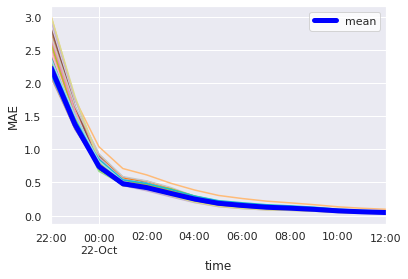

plotting


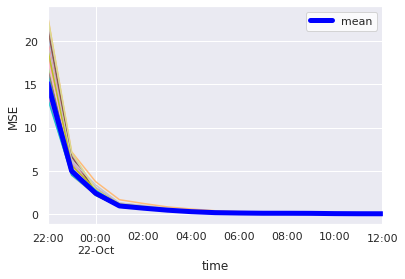

plotting


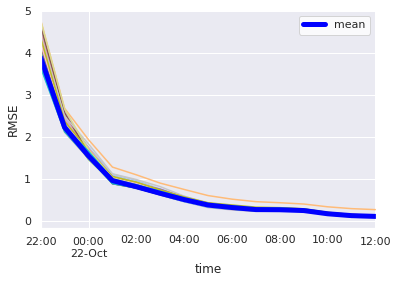

In [17]:
#  MAE, MSE, RMSE as function of time.
%autoreload
sns.set()
sns.set_style('whitegrid')
ensemble_tools.plot_ens_accuracy(dft2,'MAE')
plt.savefig(gdir + 'run{}_mae_ts_t{}.{}'.format(tag,threshold,graphicstype))
plt.show()
ensemble_tools.plot_ens_accuracy(dft2,'MSE')
plt.savefig(gdir + 'run{}_mse_ts_t{}.{}'.format(tag,threshold,graphicstype))
plt.show()
ensemble_tools.plot_ens_accuracy(dft2,'RMSE')
plt.savefig(gdir + 'run{}_rmse_ts_t{}.{}'.format(tag,threshold,graphicstype))

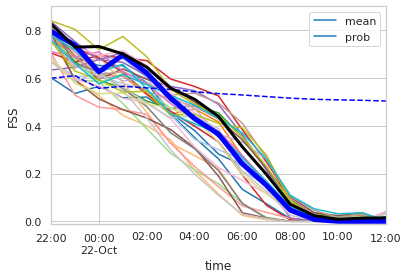

In [18]:
# FSS at one neightborhood size as a function of time.
# different colored lines are the different ensemble members.
# Uses output from the cell above.
%autoreload
sns.set()
sns.set_style('whitegrid')
# grid size is 0.1 degrees.
# neighborhood gives the number of grid squares to
# look at. 10 would be a 1degree x 1 degree area.
neighborhood = 3
ensemble_tools.plot_ens_fss_ts(dft,nval=neighborhood)
ax = plt.gca()
ax.set_ylim(-0.01,0.9)
plt.savefig(gdir + 'run{}_fss_ts_n{}_t{}.{}'.format(tag,neighborhood,threshold,graphicstype))

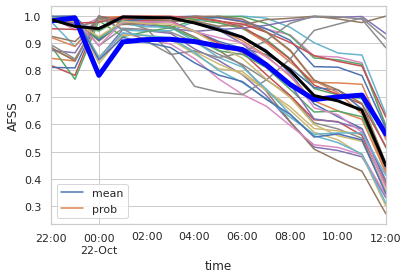

In [36]:
# plots the AFSS which is a measure of frequency bias as a function of time.
# The FSS will approach this value as neighborhood size approaches domain size.
# When pixel matching is used, this will always be 1.
%autoreload
afss = ensemble_tools.plot_afss_ts(dft)
plt.savefig(gdir + 'run{}_afss_ts_t{}.{}'.format(tag,threshold,graphicstype))

In [72]:
# Look at one time period, different neighbhorhood sizes.
%autoreload
tii=8
pixel_match=False
threshold=0.1
threshstr = str(threshold).replace('.','p')
timeval = aeval.cdump.time.values[tii]
print(timeval)
volcat,forecast = aeval.get_pair(tii)
print(aeval.concmult)
#forecast = aeval.cdump_hash[tii]
nb = np.arange(1,21,2)
nb = np.append(nb,[31,41,51])
if tii > 8:
    nb = np.append(nb,[61,71,81,91,101])
thresh=0.1
nb = [11,81,91]
# msc and psc are CalcScores objects.
# msc is for the ensemble mean (deterinistic)
# psc is for the probabilistic model field.
msc, psc, df1, dfmae = ensemble_tools.ens_fss(forecast,volcat,threshold=threshold,
                                       neighborhoods=nb,
                                       return_objects=True,plot=False,
                                       pixel_match=pixel_match)

2020-10-22T04:00:00.000000000
1


In [73]:
volcat

<xarray.DataArray 'ash_mass_loading' (y: 94, x: 71)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * y          (y) int64 392 393 394 395 396 397 398 ... 480 481 482 483 484 485
  * x          (x) int64 864 865 866 867 868 869 870 ... 929 930 931 932 933 934
    longitude  (y, x) float64 156.9 157.0 157.1 157.2 ... 163.7 163.8 163.9
    latitude   (y, x) float64 50.08 50.08 50.08 50.08 ... 59.38 59.38 59.38

In [80]:
%autoreload
testscores = plume_stat.CalcScores(volcat.fillna(0),forecast.fillna(0),threshold=0.1,probabilistic=False)


In [83]:
testscores.binxra2

<xarray.DataArray (ens: 31, y: 94, x: 71)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * y          (y) int64 392 393 394 395 396 397 398 ... 480 481 482 483 484 485
  * x          (x) int64 864 865 866 867 868 869 870 ... 929 930 931 932 933 934
  * ens        (ens) object 'gep01' 'gep02' 'gep03' ... 'gep29' 'gep30' 'gec00'
    time       datetime64[ns] 2020-10-22T04:00:00
    source     <U2 'M4'
    latitude   (y, x) float64 50.08 50.08 50.08 50.08 ... 59.38 59.38 59.38
    longitude  (y, x) float64 156.9 157.0 157.1 157.2 ... 163.7 163.8 163.9

In [81]:
testscores.binxra1

<xarray.DataArray 'ash_mass_loading' (y: 94, x: 71)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * y          (y) int64 392 393 394 395 396 397 398 ... 480 481 482 483 484 485
  * x          (x) int64 864 865 866 867 868 869 870 ... 929 930 931 932 933 934
    longitude  (y, x) float64 156.9 157.0 157.1 157.2 ... 163.7 163.8 163.9
    latitude   (y, x) float64 50.08 50.08 50.08 50.08 ... 59.38 59.38 59.38

In [117]:
%autoreload
tframe = testscores.get_contingency_table(multi=True)

In [118]:
tframe

a       b       c       d    ens  threshold
0   3188.0  7782.0  5554.0  203706    All        0.1
1     93.0   240.0   189.0  6581.0  gep01        0.1
2     96.0   231.0   186.0  6578.0  gep02        0.1
3     73.0   229.0   209.0  6601.0  gep03        0.1
4    145.0   329.0   137.0  6529.0  gep04        0.1
5     60.0   363.0   222.0  6614.0  gep05        0.1
6     65.0   235.0   217.0  6609.0  gep06        0.1
7    144.0   301.0   138.0  6530.0  gep07        0.1
8    135.0   360.0   147.0  6539.0  gep08        0.1
9     42.0   188.0   240.0  6632.0  gep09        0.1
10   106.0   290.0   176.0  6568.0  gep10        0.1
11   126.0   146.0   156.0  6548.0  gep11        0.1
12    43.0   194.0   239.0  6631.0  gep12        0.1
13   151.0   248.0   131.0  6523.0  gep13        0.1
14    81.0   119.0   201.0  6593.0  gep14        0.1
15    89.0   144.0   193.0  6585.0  gep15        0.1
16   166.0   348.0   116.0  6508.0  gep16        0.1
17    48.0    77.0   234.0  6626.0  gep17        0.1
18   148.0   337.0   134.0  6526.0  gep18        0.1
19   155.0   286.0   127.0  6519.0  gep19        0.1
20    97.0   192.0   185.0  6577.0  gep20        0.1
21    74.0   279.0   208.0  6600.0  gep21        0.1
22   131.0   298.0   151.0  6543.0  gep22        0.1
23    74.0   238.0   208.0  6600.0  gep23        0.1
24   110.0   245.0   172.0  6564.0  gep24        0.1
25    46.0   224.0   236.0  6628.0  gep25        0.1
26   131.0   268.0   151.0  6543.0  gep26        0.1
27    74.0    91.0   208.0  6600.0  gep27        0.1
28   116.0   280.0   166.0  6558.0  gep28        0.1
29   122.0   367.0   160.0  6552.0  gep29        0.1
30   161.0   371.0   121.0  6513.0  gep30        0.1
31    86.0   264.0   196.0  6588.0  gec00        0.1

In [121]:
tframe['test'] = tframe.apply(lambda row: row['a'] * row['b'],axis=1)

In [122]:
%autoreload
testscores.table2csi(tframe)

a       b       c       d    ens  threshold        test       CSI  \
0   3188.0  7782.0  5554.0  203706    All        0.1  24809016.0  0.192931   
1     93.0   240.0   189.0  6581.0  gep01        0.1     22320.0  0.178161   
2     96.0   231.0   186.0  6578.0  gep02        0.1     22176.0  0.187135   
3     73.0   229.0   209.0  6601.0  gep03        0.1     16717.0  0.142857   
4    145.0   329.0   137.0  6529.0  gep04        0.1     47705.0  0.237316   
5     60.0   363.0   222.0  6614.0  gep05        0.1     21780.0  0.093023   
6     65.0   235.0   217.0  6609.0  gep06        0.1     15275.0  0.125725   
7    144.0   301.0   138.0  6530.0  gep07        0.1     43344.0  0.246998   
8    135.0   360.0   147.0  6539.0  gep08        0.1     48600.0  0.210280   
9     42.0   188.0   240.0  6632.0  gep09        0.1      7896.0  0.089362   
10   106.0   290.0   176.0  6568.0  gep10        0.1     30740.0  0.185315   
11   126.0   146.0   156.0  6548.0  gep11        0.1     18396.0  0.294393   
12    43.0   194.0   239.0  6631.0  gep12        0.1      8342.0  0.090336   
13   151.0   248.0   131.0  6523.0  gep13        0.1     37448.0  0.284906   
14    81.0   119.0   201.0  6593.0  gep14        0.1      9639.0  0.201995   
15    89.0   144.0   193.0  6585.0  gep15        0.1     12816.0  0.208920   
16   166.0   348.0   116.0  6508.0  gep16        0.1     57768.0  0.263492   
17    48.0    77.0   234.0  6626.0  gep17        0.1      3696.0  0.133705   
18   148.0   337.0   134.0  6526.0  gep18        0.1     49876.0  0.239095   
19   155.0   286.0   127.0  6519.0  gep19        0.1     44330.0  0.272887   
20    97.0   192.0   185.0  6577.0  gep20        0.1     18624.0  0.204641   
21    74.0   279.0   208.0  6600.0  gep21        0.1     20646.0  0.131907   
22   131.0   298.0   151.0  6543.0  gep22        0.1     39038.0  0.225862   
23    74.0   238.0   208.0  6600.0  gep23        0.1     17612.0  0.142308   
24   110.0   245.0   172.0  6564.0  gep24        0.1     26950.0  0.208729   
25    46.0   224.0   236.0  6628.0  gep25        0.1     10304.0  0.090909   
26   131.0   268.0   151.0  6543.0  gep26        0.1     35108.0  0.238182   
27    74.0    91.0   208.0  6600.0  gep27        0.1      6734.0  0.198391   
28   116.0   280.0   166.0  6558.0  gep28        0.1     32480.0  0.206406   
29   122.0   367.0   160.0  6552.0  gep29        0.1     44774.0  0.187982   
30   161.0   371.0   121.0  6513.0  gep30        0.1     59731.0  0.246554   
31    86.0   264.0   196.0  6588.0  gec00        0.1     22704.0  0.157509   

         FAR         F       POD         N        aref       GSS  
0   0.709389  0.036796  0.364676  220230.0  435.452663  0.171087  
1   0.720721  0.035185  0.329787    7103.0   13.220611  0.156805  
2   0.706422  0.033926  0.340426    7091.0   13.004372  0.165993  
3   0.758278  0.033529  0.258865    7112.0   11.974691  0.122289  
4   0.694093  0.047973  0.514184    7140.0   18.721008  0.213209  
5   0.858156  0.052028  0.212766    7259.0   16.432842  0.069312  
6   0.783333  0.034337  0.230496    7126.0   11.872018  0.105177  
7   0.676404  0.044064  0.510638    7113.0   17.642345  0.223500  
8   0.727273  0.052181  0.478723    7181.0   19.438797  0.185622  
9   0.817391  0.027566  0.148936    7102.0    9.132639  0.071316  
10  0.732323  0.042286  0.375887    7140.0   15.640336  0.162412  
11  0.536765  0.021811  0.446809    6976.0   10.995413  0.275787  
12  0.818565  0.028425  0.152482    7107.0    9.403968  0.072002  
13  0.621554  0.036627  0.535461    7053.0   15.953211  0.262713  
14  0.595000  0.017729  0.287234    6994.0    8.064055  0.185618  
15  0.618026  0.021400  0.315603    7011.0    9.371844  0.191125  
16  0.677043  0.050758  0.588652    7138.0   20.306528  0.238962  
17  0.616000  0.011487  0.170213    6985.0    5.046528  0.121353  
18  0.694845  0.049104  0.524823    7145.0   19.142057  0.214814  
19  0.648526  0.042028  0.549645    7087.0   17.547905  0.249708  
20  0.664360  0.028365  0.3

In [ ]:
# Plots of 
fig = plt.figure(1,figsize=[20,5])
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
chash = {'label': 'P > {} g/m$^2$'.format(threshold)}
msc.binxra2.plot.pcolormesh(ax=ax1,x='longitude',y='latitude', cbar_kwargs=chash)
psc.binxra2.plot.pcolormesh(ax=ax2,x='longitude',y='latitude', cbar_kwargs=chash)
psc.binxra1.plot.pcolormesh(ax=ax3,x='longitude',y='latitude',cbar_kwargs=chash)
ax1.set_title('Ensemble mean Run{}'.format(tag))
ax2.set_title('Probabilistic Run{}'.format(tag))
ax3.set_title('VOLCAT composite')
timeval = pd.to_datetime(timeval)
timestr = timeval.strftime("%Y%m%dT%H")
timeval2 = timeval + datetime.timedelta(hours=1)
timestr2 = timeval2.strftime("T%H")
plt.savefig(gdir + 'binary_fields_run{}_t_{}_{}_{}'.format(tag,threshstr,timestr,timestr2))

[0.54225352]


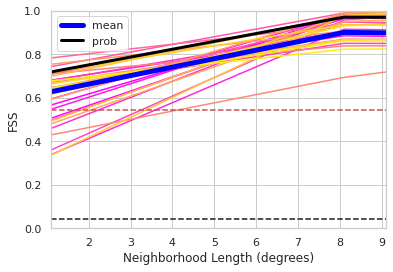

In [85]:
%autoreload
sns.set()
sns.set_style('whitegrid')
print(df1['uniform'].unique())
ensemble_tools.plot_ens_fss(df1,sizemult=0.1)
ax = plt.gca()
ax.set_ylim([0,1])
ax.set_ylabel('FSS')
ax.set_xlabel('Neighborhood Length (degrees)')
plt.savefig(gdir + 'FSS_run{}_t{}_{}_{}'.format(tag, threshstr, timestr,timestr2))

In [86]:
df1[df1.ens=='mean']

Nlen       FBS   FBS_ref       FSS    random   uniform      afss   ens  \
11    11  0.017296  0.046516  0.628182  0.042254  0.542254  0.906006  mean   
81    81  0.000417  0.004202  0.900844  0.042254  0.542254  0.906006  mean   
91    91  0.000319  0.003141  0.898439  0.042254  0.542254  0.906006  mean   

                  time  length (degrees)  
11 2020-10-22 04:00:00               1.1  
81 2020-10-22 04:00:00               8.1  
91 2020-10-22 04:00:00               9.1

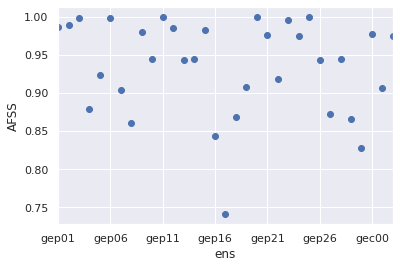

In [87]:
sns.set()
ensemble_tools.plot_afss(df1)

In [88]:
# Calculate ROC curve using 
xlist, ylist = psc.calc_roc(clip=True)
plume_stat.plot_roc(xlist,ylist)
threshstr = str(threshold).replace('.','p')
plt.savefig(gdir + 'ROC_run{}_t{}_{}_{}'.format(tag,threshstr, timestr,timestr2))

NameError: name 'csihash' is not defined

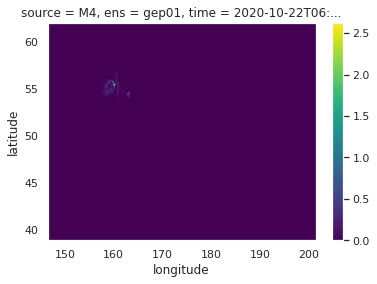

In [37]:
aeval.massload.sel(ens='gep01').isel(time=10).plot.pcolormesh(x='longitude',y='latitude')

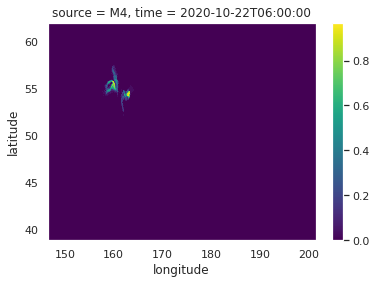

In [38]:
%autoreload
sns.set()
temp = aeval.massload
atl = ensemble_tools.ATL(temp,thresh=0.2)
atl.isel(time=10).plot.pcolormesh(x='longitude',y='latitude')

In [39]:
dim = 'ens'
temp[dim].values

array(['gep01', 'gep02', 'gep03', 'gep04', 'gep05', 'gep06', 'gep07',
       'gep08', 'gep09', 'gep10', 'gep11', 'gep12', 'gep13', 'gep14',
       'gep15', 'gep16', 'gep17', 'gep18', 'gep19', 'gep20', 'gep21',
       'gep22', 'gep23', 'gep24', 'gep25', 'gep26', 'gep27', 'gep28',
       'gep29', 'gep30', 'gec00'], dtype=object)

In [ ]:
%autoreload
tii = 8  # time period
print(aeval.massload.time.values[tii])
# Comparison of some of the different ensemble members
fig = aeval.compare_forecast(aeval.massload.sel(ens='gep26').isel(time=tii),vloc=vloc)
plt.show()
fig = aeval.compare_forecast(aeval.massload.sel(ens='gep05').isel(time=tii),vloc=vloc)
plt.show()
fig = aeval.compare_forecast(aeval.massload.sel(ens='gep10').isel(time=tii),vloc=vloc)
plt.show()
fig = aeval.compare_forecast(aeval.massload.sel(ens='gep10').isel(time=tii),vloc=vloc)
plt.show()
# mean of ensemble
fig = aeval.compare_forecast(aeval.massload.mean(dim='ens').isel(time=tii),vloc=vloc)
plt.show()
# maximum of ensemble
fig = aeval.compare_forecast(aeval.massload.max(dim='ens').isel(time=tii),vloc=vloc)

# Comparing CDF

In [ ]:
%autoreload
# one ensemble member at all times.
tii=5
timelist = aeval.massload.time.values
enslist = aeval.massload.ens.values
enslist = [enslist[tii]]
#timelist = [aeval.massload.time.values[tii]]
print(timelist)
#print(enslist)
threshold = 0.2
# CDF with pixel matching. Threshold will be different for every ensemble member as well as fo
# volcat data. First threshold is applied to VOLCAT data. Number of VOLCAT pixels above threshold
# is counted.
use_pixel_match=False
aeval.mass_cdf_plot(timelist,enslist,threshold=threshold,use_pixel_match=use_pixel_match)
ax = plt.gca()
#add_lines(ax)
plt.show()
#use_pixel_match=False
#kslist = aeval.mass_cdf_plot(timelist,enslist,threshold=threshold,use_pixel_match=use_pixel_match)
#ax = plt.gca()
#add_lines(ax)

[numpy.datetime64('2020-10-22T04:00:00.000000000')]


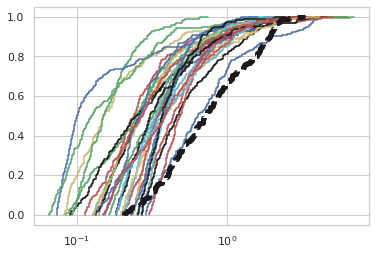

<Figure size 432x288 with 0 Axes>

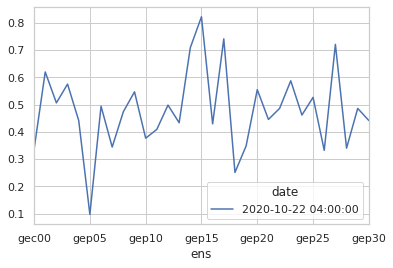

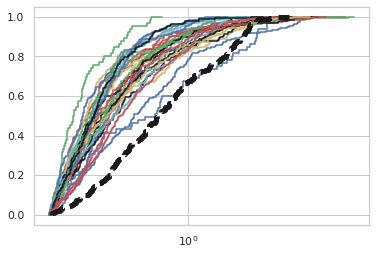

<Figure size 432x288 with 0 Axes>

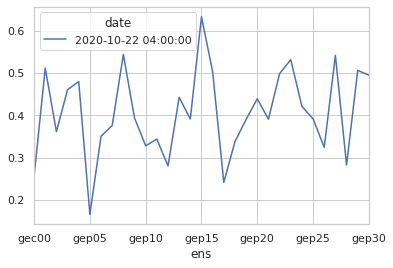

In [93]:
%autoreload
# CDF for all ensemble members at one time.
tii=8  # choose time index
timelist = aeval.massload.time.values
enslist = aeval.massload.ens.values
enslist = None
timelist = [aeval.massload.time.values[tii]]
print(timelist)
#print(enslist)l.
threshold = 0.2
# CDF with pixel matching. Threshold will be different for every ensemble member as well as fo
# volcat data. First threshold is applied to VOLCAT data. Number of VOLCAT pixels above threshold
# is counted.
use_pixel_match=True
aeval.mass_cdf_plot(timelist,enslist,threshold=threshold,use_pixel_match=use_pixel_match)
ax = plt.gca()
#add_lines(ax)
plt.show()
# CDF with no pixel matching. Thresholds are the same for every ensemble member and volcat data.
# number of above threshold pixels will be different.
use_pixel_match=False
kslist = aeval.mass_cdf_plot(timelist,enslist,threshold=threshold,use_pixel_match=use_pixel_match)
ax = plt.gca()
#add_lines(ax)


# ROC diagrams

In [131]:
%autoreload
tii = 10
volcat = aeval.volcat_avg_hash[tii]
forecast = aeval.cdump_hash[tii]
probscores = plume_stat.CalcScores(volcat, forecast,threshold=0.1,probabilistic=True)


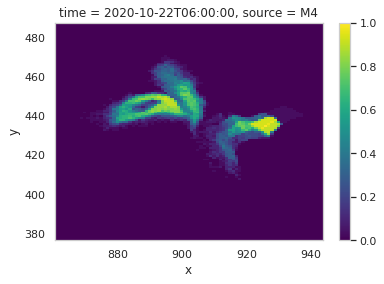

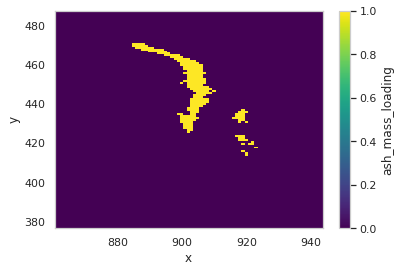

In [132]:
probscores.binxra2.plot.pcolormesh()
plt.show()
probscores.binxra1.plot.pcolormesh()

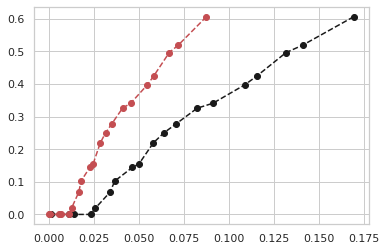

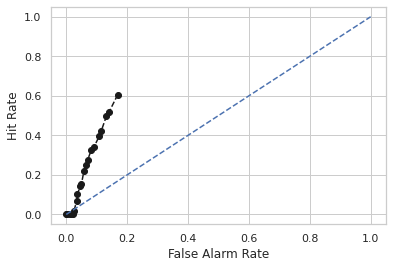

In [138]:
%autoreload
sns.set()
sns.set_style('whitegrid')
pm=True
datedf1 = pd.to_datetime(aeval.cdump.time.values[tii])
timetag = datedf1.strftime("%Y%m%dT%H")
if pm: timetag + '_pm'

xlist, ylist = probscores.calc_roc(clip=True)
xlist2,ylist2 = probscores.calc_roc(clip=False)
plt.plot(xlist,ylist,'--ko')
plt.plot(xlist2,ylist2,'--ro')
plt.show()
plume_stat.plot_roc(xlist,ylist)
plt.savefig(gdir + 'ROC_run{}_{}'.format(tag,timetag))
#plume_stat.plot_roc(xlist2,ylist2)

# Reliability Curves

In [139]:
from utilhysplit.evaluation import reliability


In [140]:
tii = 8
volcat = aeval.volcat_avg_hash[tii]
forecast = aeval.cdump_hash[tii]

In [141]:
print(aeval.cdump.time.values[16])

2020-10-22T12:00:00.000000000


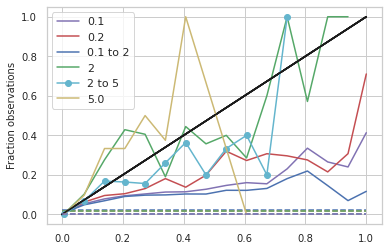

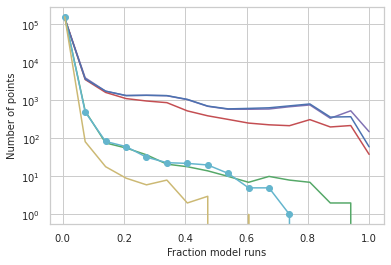

In [142]:
%autoreload
num=15  #number of bins to use on x axis.
# 
threshlist = [0.1,0.2,[0.1,2],2,[2,5],5.0]
clrs = ['-m','-r','-b','-g','-co','-y']
rclist = []
labels = []
fig = plt.figure(1)
ax = fig.add_subplot(1,1,1)
fig2 = plt.figure(2)
ax2 = fig2.add_subplot(1,1,1)
for thresh in threshlist:
    if isinstance(thresh,(float,int)):
        labels.append(str(thresh))
    else:
        labels.append('{} to {}'.format(thresh[0],thresh[1]))
    rclist.append(reliability.ReliabilityCurve(thresh,num))
# time periods to include in reliability diagram.
#for tii in [3,4,5,6]:
for tii in [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]:
    volcat = aeval.volcat_avg_hash[tii]
    forecast = aeval.cdump_hash[tii]
    for jjj, rc in enumerate(rclist):
        dfin = rc.reliability_add_xra(volcat,forecast,fill=True)

for jjj, rc in enumerate(rclist):
    reliability.sub_reliability_plot(rc,ax,clr=clrs[jjj],fs=10,label=labels[jjj])
    reliability.sub_reliability_number_plot(rc,ax2,clr=clrs[jjj],fs=10,label=labels[jjj])
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,labels,loc='upper left')

0.1


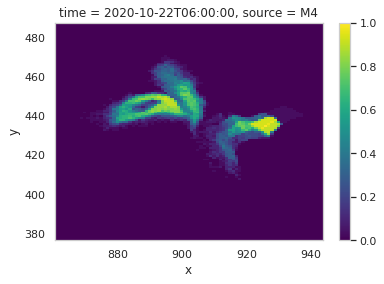

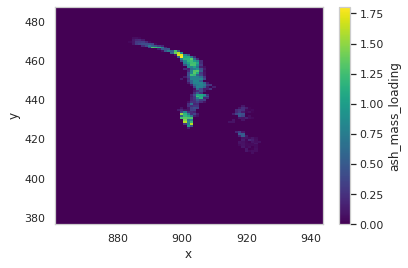

In [54]:
print(thresh)
prob = ensemble_tools.ATL(forecast,thresh=thresh,norm=True)
prob.plot.pcolormesh()
plt.show()
volcat.plot.pcolormesh()

ROW ens
obs      0.000000
gep26    0.000000
gep24    0.000000
gep19    0.000000
gep04    0.000000
gep13    0.000000
gep11    0.000000
gep10    0.000000
gep12    0.000039
gep18    0.000309
gep30    0.000329
gec00    0.000781
gep07    0.000992
gep09    0.002250
gep23    0.002893
gep29    0.003158
gep16    0.003179
gep08    0.003664
gep20    0.004616
gep17    0.005871
gep06    0.006093
gep22    0.006219
gep15    0.006227
gep28    0.008730
gep02    0.010692
gep14    0.011502
gep25    0.020243
gep27    0.027061
gep03    0.030351
gep21    0.034671
gep01    0.062099
gep05    0.145643
Name: 876_439, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep13    0.000000
gep11    0.000000
gep18    0.000000
gep24    0.000000
gep19    0.000000
gep26    0.000000
gep04    0.000000
gep30    0.000331
gep28    0.000898
gep07    0.001032
gep29    0.001055
gep16    0.001938
gep20    0.002007
gep17    0.002946
gep23    0.003881
gep12    0.003931
gep06    0.004098
gep09    0.004519
gep10    0.004756
gec00  

Rank 0 0.0
ROW ens
obs      0.000000
gep13    0.000000
gep24    0.000000
gep04    0.000000
gep11    0.000074
gep19    0.000237
gep30    0.004778
gep07    0.005559
gep26    0.009644
gep16    0.016421
gep09    0.017935
gep06    0.019654
gep23    0.020301
gep29    0.022172
gep08    0.024006
gep14    0.028446
gep20    0.036075
gep22    0.037945
gep10    0.038157
gep17    0.038781
gep18    0.039325
gep12    0.041482
gep15    0.041735
gep02    0.048455
gep27    0.077735
gec00    0.079493
gep28    0.098304
gep25    0.203143
gep21    0.374459
gep01    0.425760
gep03    0.502546
gep05    0.594428
Name: 881_445, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep04    0.000000
gep24    0.000000
gep11    0.000000
gep19    0.000269
gep30    0.000447
gep13    0.000613
gep07    0.001041
gep09    0.001961
gep08    0.003664
gep29    0.004197
gep10    0.004481
gep27    0.004587
gep16    0.005211
gep06    0.006002
gep26    0.006446
gep14    0.006452
gep20    0.006539
gep17    0.011973
gep22    0.012

Name: 885_439, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.000241
gep24    0.000696
gep13    0.001173
gep04    0.001638
gep11    0.005220
gep30    0.025554
gep26    0.031480
gep07    0.033606
gep18    0.036079
gep16    0.036208
gep12    0.046533
gep17    0.046564
gep23    0.057768
gep27    0.061223
gep14    0.083517
gep08    0.094240
gep02    0.095531
gep15    0.123005
gep28    0.130168
gep10    0.139684
gep20    0.186347
gep25    0.186626
gep06    0.186944
gep01    0.199881
gep29    0.209923
gep03    0.225367
gep09    0.233776
gec00    0.234087
gep22    0.264841
gep21    0.394079
gep05    0.651413
Name: 885_440, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.000168
gep13    0.001283
gep24    0.001452
gep04    0.004675
gep11    0.005093
gep26    0.020948
gep17    0.026721
gep12    0.036826
gep27    0.055789
gep07    0.057958
gep15    0.060189
gep18    0.060384
gep08    0.070667
gep16    0.073892
gep30    0.080636
gep02    0.085781
gep14    0.091171
ge

Rank 0 0.0
ROW ens
obs      0.000000
gep01    0.000000
gep02    0.000000
gep27    0.000000
gep05    0.000000
gep20    0.000000
gep14    0.000000
gep03    0.000003
gep23    0.000619
gep22    0.001074
gep11    0.001228
gep25    0.001404
gep09    0.002043
gep12    0.002255
gep15    0.002641
gep21    0.003331
gep24    0.006076
gep17    0.009194
gep28    0.013860
gec00    0.016401
gep13    0.018140
gep10    0.019244
gep06    0.020405
gep26    0.021435
gep16    0.035574
gep04    0.036111
gep29    0.041527
gep07    0.046113
gep08    0.048857
gep19    0.055696
gep30    0.073475
gep18    0.140210
Name: 887_460, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep26    0.000000
gep04    0.000000
gep19    0.000000
gep24    0.000012
gep11    0.000024
gep12    0.000317
gep18    0.000540
gep02    0.000682
gep13    0.001340
gep16    0.001426
gep29    0.002181
gep20    0.002275
gep07    0.002333
gec00    0.003335
gep30    0.004066
gep03    0.004934
gep06    0.005204
gep14    0.006170
gep10    0.007

ROW ens
obs      0.000000
gep01    0.000000
gep03    0.000729
gep25    0.000792
gep20    0.001786
gep23    0.002436
gep09    0.003631
gep27    0.003977
gep14    0.004791
gep02    0.005172
gep05    0.005565
gep22    0.006355
gep12    0.006659
gep26    0.007057
gep21    0.009891
gep15    0.010869
gep11    0.014238
gep17    0.020498
gep10    0.026413
gep13    0.026600
gec00    0.026972
gep06    0.028407
gep24    0.050996
gep29    0.083503
gep16    0.103940
gep07    0.133008
gep28    0.133140
gep18    0.134626
gep19    0.144948
gep08    0.162211
gep30    0.201966
gep04    0.243731
Name: 889_455, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep01    0.000000
gep25    0.000774
gep03    0.001113
gep27    0.001266
gep20    0.001420
gep14    0.001620
gep22    0.002128
gep21    0.003419
gep12    0.004449
gep09    0.004460
gep23    0.005898
gep11    0.006067
gep05    0.007451
gep15    0.008692
gep10    0.009304
gep02    0.013256
gec00    0.016234
gep17    0.018237
gep13    0.038215
gep06  

Rank 0 0.0
ROW ens
obs      0.000000
gep27    0.004516
gep17    0.016001
gep14    0.031014
gep15    0.032433
gep09    0.033212
gep20    0.036767
gep22    0.087823
gep12    0.182260
gep19    0.202219
gep01    0.216168
gep02    0.222987
gep03    0.275595
gep10    0.287539
gep25    0.288363
gep05    0.294326
gec00    0.305213
gep11    0.325958
gep23    0.420036
gep29    0.421017
gep21    0.421497
gep06    0.474919
gep07    0.495327
gep13    0.499373
gep16    0.635656
gep26    0.707992
gep24    1.164664
gep28    1.221563
gep04    1.287675
gep08    1.343342
gep18    1.358652
gep30    1.482474
Name: 891_447, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep27    0.042529
gep17    0.043253
gep20    0.056008
gep15    0.072337
gep14    0.076279
gep09    0.087340
gep11    0.145122
gep22    0.153944
gep12    0.197397
gep19    0.209786
gep01    0.250248
gep06    0.251832
gep07    0.274919
gep02    0.298602
gep10    0.313714
gep29    0.353179
gep03    0.359463
gep23    0.383375
gec00    0.428

Rank 0 0.0
ROW ens
obs      0.000000
gep14    0.000000
gep03    0.000007
gep27    0.000034
gep20    0.000306
gep11    0.001242
gep02    0.005130
gep26    0.007186
gep15    0.007229
gep05    0.008200
gep06    0.010392
gep21    0.012983
gep25    0.014574
gep12    0.020178
gep22    0.023914
gec00    0.024969
gep13    0.026510
gep17    0.031198
gep01    0.033012
gep09    0.035896
gep23    0.045905
gep24    0.055629
gep10    0.060308
gep07    0.110698
gep18    0.124675
gep29    0.128437
gep08    0.136423
gep28    0.156940
gep04    0.160774
gep19    0.171760
gep16    0.183210
gep30    0.246056
Name: 892_464, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep27    0.000000
gep26    0.000000
gep20    0.000000
gep14    0.000000
gep11    0.000000
gep03    0.000002
gep21    0.002335
gep02    0.002682
gep25    0.003331
gep06    0.004348
gep13    0.007256
gep15    0.007344
gep12    0.008707
gep09    0.011094
gep24    0.013056
gec00    0.014841
gep01    0.016529
gep17    0.025681
gep05    0.028

Rank 0 0.0
ROW ens
obs      0.000000
gep25    0.017700
gep23    0.032698
gep12    0.033825
gep06    0.035001
gep03    0.035060
gep14    0.037717
gep09    0.040996
gep01    0.049605
gep21    0.053019
gep20    0.054459
gep22    0.076337
gec00    0.084091
gep17    0.085348
gep05    0.096751
gep15    0.105365
gep11    0.108335
gep27    0.114294
gep26    0.121630
gep10    0.138581
gep02    0.167811
gep28    0.220700
gep16    0.244461
gep29    0.290683
gep08    0.297702
gep30    0.307116
gep13    0.349382
gep24    0.398304
gep07    0.408175
gep18    0.409458
gep04    0.523591
gep19    0.601332
Name: 894_454, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep01    0.027240
gep09    0.028972
gep25    0.031650
gep06    0.032833
gep21    0.033354
gep14    0.038127
gep03    0.043017
gep12    0.050853
gep23    0.052888
gep20    0.053176
gep11    0.064902
gec00    0.076616
gep17    0.082671
gep22    0.088403
gep15    0.100545
gep05    0.106438
gep10    0.109485
gep27    0.120808
gep26    0.139

Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.001665
gep12    0.002797
gep02    0.004226
gep07    0.007555
gep04    0.007964
gep11    0.008452
gep18    0.009064
gep13    0.009434
gep09    0.010149
gep20    0.010255
gep14    0.012019
gep24    0.013085
gep03    0.013089
gep06    0.016234
gep27    0.017842
gep08    0.018814
gep23    0.020083
gec00    0.020097
gep30    0.022618
gep25    0.022750
gep28    0.023718
gep15    0.027453
gep10    0.032973
gep29    0.037656
gep21    0.037798
gep26    0.039980
gep17    0.051204
gep22    0.057570
gep16    0.057629
gep01    0.070124
gep05    0.168584
Name: 896_440, dtype: float64
Rank 0 0.0
ROW ens
gep12    0.005162
gep19    0.013361
gep02    0.014233
gep20    0.014538
gep24    0.014947
gep06    0.015190
gep11    0.019749
gep14    0.022215
gep09    0.024424
gep03    0.027557
gep23    0.027737
gep04    0.029434
gep16    0.029445
gep17    0.031052
gep07    0.032110
gep10    0.033464
gep28    0.036139
gep13    0.037202
gec00    0.037229
gep22    0.050

Rank 25 0.30675140023231506
ROW ens
gep06    0.018329
gep11    0.025962
gep25    0.031925
gep03    0.044011
gep14    0.046584
gep21    0.064059
gep20    0.074677
gep23    0.091499
gep09    0.093128
gep15    0.096743
gep17    0.096787
gep12    0.096933
gep27    0.097928
gep01    0.107707
gep05    0.108908
gep22    0.109281
gep08    0.141867
gec00    0.148660
gep26    0.158238
gep02    0.160656
gep24    0.165254
gep29    0.165675
gep28    0.189873
gep07    0.211949
gep04    0.226854
gep10    0.229310
gep18    0.292215
gep13    0.361374
gep16    0.491487
gep19    0.544480
gep30    0.567454
obs      0.682653
Name: 897_459, dtype: float64
Rank 31 0.6826528906822205
ROW ens
obs      0.000000
gep11    0.006454
gep14    0.011228
gep06    0.016771
gep03    0.019899
gep25    0.024066
gep20    0.050846
gep21    0.053556
gep27    0.057365
gep01    0.066314
gep26    0.071001
gep05    0.074964
gep02    0.076489
gep09    0.080328
gep15    0.083787
gep12    0.096250
gep22    0.097720
gec00    0.107491

Rank 31 1.309840440750122
ROW ens
gep24    0.024448
gep07    0.029379
gep25    0.037013
gep06    0.038059
gep09    0.042347
gep10    0.044708
gep05    0.050078
gep02    0.055316
gep12    0.056839
gep20    0.057668
gep04    0.061857
gep19    0.062428
gep23    0.064138
gep27    0.072218
gep17    0.076474
gec00    0.094909
gep14    0.108837
gep18    0.114631
gep08    0.115258
gep28    0.127382
gep29    0.129240
gep11    0.136964
gep30    0.139469
gep26    0.142380
gep03    0.150747
gep15    0.168750
gep01    0.172359
gep16    0.187245
gep13    0.192251
gep21    0.204157
gep22    0.256496
obs      1.360952
Name: 899_443, dtype: float64
Rank 31 1.3609520196914673
ROW ens
gep07    0.034013
gep23    0.034837
gep25    0.036276
gep06    0.038662
gep09    0.042179
gep24    0.047484
gep02    0.053483
gep20    0.060479
gep17    0.075246
gep19    0.075381
gep05    0.087340
gep12    0.088255
gep04    0.091458
gep30    0.094833
gep27    0.096716
gep10    0.115639
gep28    0.135951
gep03    0.144335
g

Rank 31 0.761285126209259
ROW ens
gep23    0.003372
gep09    0.014057
gep06    0.017767
gep12    0.019521
gep05    0.023335
gep17    0.041731
gep28    0.047096
gep16    0.047124
gep10    0.055598
gep08    0.060718
gep22    0.066418
gep01    0.071476
gep30    0.075754
gep21    0.083083
gep25    0.085347
gep18    0.098630
gep24    0.099300
gep15    0.102215
gep14    0.110597
gep29    0.120245
gep19    0.122773
gep03    0.153123
gep13    0.160298
gep02    0.165699
gep04    0.168448
gep07    0.202603
gec00    0.206300
gep26    0.284775
gep27    0.308372
gep20    0.346698
gep11    0.418003
obs      1.284557
Name: 900_454, dtype: float64
Rank 31 1.2845567464828491
ROW ens
gep23    0.006020
gep09    0.009865
gep06    0.013105
gep17    0.019999
gep12    0.021467
gep05    0.028203
gep28    0.033069
gep25    0.043667
gep29    0.044772
gep10    0.049887
gep19    0.052211
gep16    0.056907
gep22    0.057551
gep14    0.060725
gep08    0.061990
gep01    0.066008
gep21    0.069225
gep07    0.073185
g

ROW ens
gep11    0.002384
gep06    0.004892
gep21    0.007136
gep27    0.008390
gep20    0.010717
gep14    0.010920
gep25    0.015020
gep02    0.016126
gep24    0.016681
gep03    0.016930
gep04    0.017995
gep01    0.021781
gep26    0.021965
gep29    0.022661
gep08    0.026485
gep15    0.027880
gep12    0.028692
gep09    0.028883
gec00    0.032406
gep22    0.033004
gep17    0.040505
gep05    0.044928
gep13    0.047046
gep07    0.051886
gep18    0.054138
gep23    0.064014
gep10    0.084023
gep28    0.099129
gep16    0.120681
gep30    0.143481
gep19    0.158971
obs      2.113791
Name: 901_462, dtype: float64
Rank 31 2.113790988922119
ROW ens
gep26    0.000000
gep11    0.000000
gep03    0.001737
gep06    0.002629
gep14    0.004159
gep21    0.004343
gep24    0.004855
gep20    0.005098
gep25    0.005510
gep02    0.008610
gep04    0.010521
gep27    0.011845
gep01    0.017213
gep15    0.017831
gep09    0.018838
gep22    0.021325
gep17    0.022264
gep23    0.024188
gep29    0.025662
gep12    0

Rank 0 0.0
ROW ens
obs      0.000000
gep01    0.000000
gep28    0.000000
gep25    0.000000
gep11    0.000998
gep05    0.001630
gep21    0.001753
gep12    0.002016
gep03    0.002456
gep15    0.009365
gep20    0.021595
gep17    0.022877
gep27    0.026008
gep14    0.033610
gep09    0.034096
gep02    0.056183
gep23    0.068234
gep06    0.077871
gep24    0.083492
gep07    0.090057
gec00    0.117330
gep22    0.139332
gep10    0.147572
gep13    0.154023
gep30    0.155622
gep18    0.167666
gep16    0.169856
gep08    0.178227
gep26    0.196716
gep04    0.206363
gep19    0.320002
gep29    0.402034
Name: 903_432, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep02    0.000000
gep28    0.000000
gep05    0.000000
gep12    0.000000
gep25    0.000255
gep11    0.000999
gep21    0.001001
gep01    0.001550
gep14    0.003611
gep15    0.005168
gep17    0.006544
gep03    0.008337
gep06    0.009934
gep18    0.014736
gep07    0.014864
gep24    0.019300
gep27    0.022554
gep09    0.029782
gep20    0.031

ROW ens
obs      0.000000
gep18    0.000000
gep29    0.000408
gep06    0.000408
gec00    0.000895
gep20    0.001420
gep05    0.001659
gep10    0.001782
gep04    0.001865
gep23    0.002027
gep09    0.002257
gep24    0.002370
gep12    0.003048
gep01    0.004131
gep17    0.004367
gep14    0.007575
gep11    0.007932
gep21    0.009303
gep19    0.011848
gep07    0.014128
gep26    0.015946
gep15    0.016727
gep27    0.023224
gep02    0.032380
gep03    0.033498
gep25    0.085374
gep28    0.088207
gep13    0.091077
gep30    0.184210
gep08    0.302714
gep22    0.314526
gep16    0.475274
Name: 904_442, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep20    0.000000
gep09    0.000910
gep19    0.001098
gep06    0.001750
gep23    0.002830
gep24    0.003396
gep04    0.004087
gep05    0.005001
gep18    0.008398
gep07    0.009033
gep11    0.009238
gep26    0.010145
gep01    0.011448
gep10    0.011749
gep15    0.012771
gec00    0.013329
gep27    0.014923
gep29    0.018377
gep14    0.027747
gep02  

ROW ens
gep15    0.000000
gep01    0.000000
gep28    0.000000
gep03    0.000000
gep05    0.000000
gep25    0.000000
gep08    0.000000
gep21    0.000000
gep16    0.000000
gep12    0.000000
gep13    0.000000
gep30    0.004288
gep22    0.006886
gep27    0.020594
obs      0.020727
gep20    0.022535
gep19    0.022844
gep11    0.023497
gec00    0.031417
gep17    0.053448
gep14    0.066283
gep09    0.073474
gep02    0.140010
gep07    0.202136
gep06    0.212244
gep26    0.249604
gep23    0.279003
gep10    0.318987
gep24    0.321309
gep04    0.371331
gep18    0.391884
gep29    0.554770
Name: 906_434, dtype: float64
Rank 14 0.020727382972836494
ROW ens
gep15    0.000000
gep28    0.000000
gep25    0.000000
gep21    0.000000
gep16    0.000000
gep13    0.000000
gep12    0.000000
gep08    0.000000
obs      0.000000
gep01    0.000000
gep05    0.000000
gep03    0.000000
gep30    0.004494
gep22    0.013531
gep27    0.024445
gep20    0.026065
gep11    0.029454
gec00    0.039019
gep19    0.041486
gep17  

ROW ens
gep15    0.000000
gep01    0.000000
gep03    0.000000
gep21    0.010144
gep12    0.013285
gep27    0.013928
gep17    0.057525
gep05    0.058369
gep02    0.059675
obs      0.078023
gep25    0.081384
gec00    0.089810
gep28    0.091547
gep14    0.099588
gep06    0.102365
gep20    0.116195
gep24    0.121907
gep10    0.127407
gep30    0.146061
gep09    0.167557
gep04    0.174061
gep16    0.185182
gep23    0.192902
gep07    0.290620
gep08    0.351911
gep11    0.354873
gep29    0.356686
gep19    0.366691
gep22    0.376595
gep18    0.398122
gep13    0.422949
gep26    0.446888
Name: 908_438, dtype: float64
Rank 9 0.07802344113588333
ROW ens
gep15    0.000000
gep01    0.000000
gep03    0.000000
gep27    0.012491
gep12    0.013657
gep21    0.015253
gep05    0.052178
gep17    0.060483
gep02    0.072423
gep28    0.089638
gep14    0.094961
gep25    0.104599
gep06    0.126069
gep24    0.134144
gep10    0.149182
gep09    0.150604
gec00    0.155450
gep20    0.160617
gep23    0.187913
obs      

Rank 31 0.8375437259674072
ROW ens
gep15    0.000000
gep01    0.000000
gep27    0.000000
gep03    0.000000
gep12    0.026976
gep21    0.034140
gec00    0.070858
gep17    0.120968
gep05    0.124934
gep02    0.132257
gep16    0.175514
gep25    0.192482
gep30    0.194587
gep14    0.221605
gep28    0.226230
gep06    0.231628
gep24    0.241466
gep09    0.253069
gep20    0.257654
gep10    0.288978
gep29    0.337870
gep19    0.357804
gep08    0.380074
gep23    0.424245
gep04    0.451991
gep22    0.546398
gep13    0.612163
gep07    0.638140
gep11    0.728855
gep18    0.763573
gep26    0.840452
obs      1.132764
Name: 911_439, dtype: float64
Rank 31 1.1327643394470215
ROW ens
gep15    0.000000
gep01    0.000000
gep27    0.000000
gep03    0.000000
gep12    0.039368
gep21    0.041869
gec00    0.108732
gep17    0.169217
gep02    0.176788
gep05    0.185473
gep28    0.201128
gep25    0.224434
gep16    0.227920
gep30    0.241214
gep14    0.244119
gep24    0.331729
gep06    0.332110
gep20    0.355919


ROW ens
gec00    0.000000
gep28    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep13    0.000000
gep10    0.000000
gep15    0.000000
gep08    0.000000
gep01    0.000000
gep03    0.000000
gep05    0.000000
obs      0.000000
gep07    0.013136
gep04    0.021988
gep06    0.061549
gep16    0.099731
gep27    0.111907
gep29    0.160822
gep17    0.179319
gep09    0.205032
gep02    0.272769
gep12    0.555394
gep14    0.564868
gep30    0.865444
gep26    0.866264
gep19    1.213729
gep18    1.560934
gep11    1.582223
gep20    1.597730
Name: 915_444, dtype: float64
Rank 14 0.0
ROW ens
gec00    0.000000
gep28    0.000000
gep25    0.000000
gep24    0.000000
gep22    0.000000
gep21    0.000000
gep10    0.000000
gep08    0.000000
gep15    0.000000
obs      0.000000
gep01    0.000000
gep03    0.000000
gep05    0.000000
gep07    0.003989
gep04    0.007454
gep23    0.017973
gep06    0.019903
gep13    0.020691
gep16    0.031734
gep27    0.034877
gep17 

ROW ens
obs      0.000000
gep08    0.024771
gep28    0.034869
gep30    0.083050
gep16    0.147094
gep29    0.160880
gep12    0.168433
gep25    0.185311
gep01    0.204225
gep15    0.207590
gep20    0.225268
gep13    0.238680
gep19    0.259241
gep05    0.268098
gep03    0.272691
gep18    0.275266
gep27    0.316460
gep23    0.316761
gep11    0.336570
gep22    0.370975
gep21    0.379272
gep04    0.395325
gep14    0.398034
gep26    0.419112
gec00    0.437764
gep24    0.553032
gep09    0.683556
gep10    0.710019
gep02    0.825202
gep07    0.830537
gep06    1.184089
gep17    2.095622
Name: 920_439, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep08    0.028107
gep28    0.035680
gep30    0.096823
gep16    0.174390
gep29    0.188425
gep01    0.213234
gep12    0.217656
gep25    0.224539
gep20    0.249151
gep15    0.259572
gep13    0.295094
gep03    0.299764
gep27    0.307182
gep05    0.315994
gep19    0.334097
gep23    0.345079
gep18    0.351167
gep11    0.361989
gep04    0.417784
gep22  

ROW ens
obs      0.000000
gep22    0.000000
gep19    0.000000
gep26    0.000000
gep13    0.000000
gep11    0.000000
gep12    0.000000
gep24    0.000000
gep01    0.000000
gep04    0.000000
gep30    0.000220
gep28    0.000224
gep18    0.000310
gep20    0.000521
gep29    0.000526
gep07    0.000590
gep16    0.000829
gep14    0.001190
gep03    0.001435
gep10    0.001867
gep06    0.002392
gep08    0.003541
gep23    0.003871
gep25    0.004057
gep09    0.004511
gec00    0.005949
gep15    0.006241
gep17    0.008839
gep27    0.009040
gep02    0.032078
gep21    0.065182
gep05    0.160462
Name: 873_440, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep26    0.000000
gep24    0.000000
gep04    0.000000
gep18    0.000000
gep13    0.000000
gep11    0.000000
gep19    0.000007
gep12    0.000039
gep30    0.000110
gep29    0.000525
gep07    0.000873
gep22    0.001103
gec00    0.001562
gep16    0.001655
gep23    0.001930
gep10    0.002791
gep06    0.003063
gep08    0.003663
gep20    0.003983
gep17  

ROW ens
obs      0.000000
gep24    0.000000
gep09    0.000000
gep08    0.000000
gep27    0.000000
gep22    0.000000
gep04    0.000000
gep01    0.000000
gep12    0.000068
gep11    0.000073
gep19    0.000142
gep07    0.000251
gep23    0.000324
gep10    0.000430
gep13    0.000597
gep30    0.000651
gep20    0.000872
gep14    0.001172
gep03    0.001467
gep16    0.001966
gep25    0.002080
gep02    0.002401
gep29    0.002645
gep15    0.003085
gep26    0.003137
gep28    0.003247
gep06    0.003432
gep18    0.004837
gep17    0.004990
gep21    0.017539
gec00    0.034963
gep05    0.198070
Name: 880_434, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep24    0.000000
gep18    0.000000
gep13    0.000000
gep11    0.000000
gep04    0.000000
gep19    0.000010
gep30    0.000268
gep02    0.000283
gep07    0.001263
gep29    0.003701
gep03    0.003744
gep06    0.004591
gep08    0.004788
gep20    0.005665
gep16    0.005733
gep12    0.005872
gep26    0.006266
gep23    0.006267
gep14    0.006545
gep22  

ROW ens
obs      0.000000
gep11    0.000024
gep24    0.000205
gep19    0.000428
gep04    0.000531
gep13    0.000930
gep07    0.005523
gep30    0.007139
gep23    0.010224
gep18    0.010654
gep12    0.010952
gep26    0.017911
gep16    0.024301
gep28    0.025098
gep22    0.025994
gep02    0.026232
gep14    0.026286
gep08    0.033961
gep17    0.034151
gec00    0.034939
gep09    0.035360
gep20    0.039510
gep03    0.039596
gep29    0.045367
gep15    0.051897
gep10    0.054598
gep06    0.070328
gep27    0.071984
gep25    0.128483
gep01    0.195276
gep21    0.307640
gep05    0.633181
Name: 883_437, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.000233
gep24    0.000746
gep13    0.000783
gep04    0.001412
gep11    0.002271
gep18    0.010258
gep07    0.019932
gep26    0.021113
gep30    0.027435
gep16    0.027672
gep12    0.034067
gep17    0.038262
gep14    0.051271
gep27    0.052631
gep23    0.053415
gep28    0.060497
gep02    0.063935
gep15    0.084862
gep06    0.091191
gep10  

ROW ens
obs      0.000000
gep19    0.000144
gep24    0.000469
gep04    0.000874
gep13    0.001321
gep11    0.007167
gep02    0.018789
gep26    0.021331
gep07    0.025520
gep12    0.027288
gep30    0.039680
gep08    0.041455
gep18    0.042527
gep17    0.048929
gep16    0.051987
gep27    0.059731
gep28    0.062377
gep23    0.068155
gep10    0.078090
gep14    0.086971
gep15    0.087175
gep20    0.088415
gep03    0.090553
gep29    0.160197
gep06    0.171079
gec00    0.177748
gep22    0.193779
gep09    0.201566
gep25    0.206115
gep01    0.284045
gep21    0.408416
gep05    0.885248
Name: 886_439, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.001186
gep24    0.004266
gep13    0.006066
gep11    0.007869
gep04    0.015645
gep27    0.040915
gep26    0.063225
gep17    0.072931
gep07    0.073667
gep12    0.088513
gep02    0.089188
gep18    0.100316
gep30    0.121370
gep14    0.127918
gep16    0.134718
gep15    0.147695
gep28    0.174030
gep23    0.180386
gep20    0.181693
gep08  

Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.000000
gep24    0.000000
gep04    0.000000
gep13    0.000000
gep11    0.000000
gep12    0.000071
gep16    0.000500
gep22    0.000802
gep07    0.000843
gep06    0.001849
gep14    0.001958
gep03    0.002427
gep02    0.002811
gep28    0.003888
gep20    0.004249
gep09    0.004683
gep29    0.005000
gep18    0.005308
gep26    0.005447
gep08    0.006523
gep23    0.006738
gec00    0.008034
gep10    0.008693
gep25    0.015464
gep15    0.021518
gep30    0.026971
gep27    0.032174
gep17    0.032341
gep01    0.039250
gep21    0.097898
gep05    0.112888
Name: 889_437, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep18    0.000000
gep26    0.000000
gep13    0.000000
gep24    0.000058
gep16    0.000492
gep19    0.000832
gep07    0.001314
gep11    0.001436
gep30    0.001682
gep09    0.002142
gep02    0.002713
gep20    0.003139
gep29    0.004154
gep03    0.004412
gep12    0.009110
gep22    0.009719
gep06    0.009740
gep10    0.009898
gep14    0.012

Rank 0 0.0
ROW ens
obs      0.000000
gep01    0.000000
gep05    0.000000
gep14    0.000000
gep20    0.000409
gep03    0.000488
gep25    0.001348
gep27    0.001535
gep09    0.002451
gep15    0.003617
gep22    0.004292
gep23    0.004930
gep21    0.006722
gep12    0.006735
gep02    0.007793
gep11    0.016868
gep17    0.018329
gep26    0.021409
gep13    0.021624
gep10    0.026379
gep06    0.027102
gec00    0.027261
gep29    0.051601
gep19    0.069426
gep24    0.069449
gep16    0.072571
gep18    0.078350
gep30    0.083932
gep28    0.095729
gep08    0.129435
gep04    0.185309
gep07    0.193688
Name: 890_459, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep01    0.000000
gep27    0.000000
gep05    0.000000
gep14    0.000000
gep25    0.000117
gep03    0.000248
gep20    0.000304
gep09    0.002044
gep23    0.002466
gep21    0.003449
gep15    0.004042
gep22    0.004300
gep12    0.007888
gep02    0.008036
gep11    0.019356
gep10    0.019827
gep17    0.025275
gec00    0.027309
gep26    0.029

ROW ens
obs      0.000000
gep27    0.013417
gep14    0.019760
gep17    0.023717
gep03    0.043286
gep15    0.050578
gep09    0.117741
gep01    0.127518
gep05    0.167928
gep22    0.199370
gep02    0.219594
gep19    0.235121
gep20    0.237813
gep25    0.276038
gep13    0.277944
gep23    0.305343
gep12    0.316298
gep10    0.373192
gep21    0.406306
gep11    0.475251
gec00    0.545016
gep16    0.554280
gep29    0.566183
gep07    0.619196
gep06    0.740204
gep24    0.849371
gep26    1.192690
gep04    1.193932
gep08    1.245876
gep28    1.275750
gep18    1.796003
gep30    2.074892
Name: 892_445, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep27    0.006145
gep17    0.006800
gep14    0.010264
gep15    0.021763
gep20    0.030880
gep09    0.031142
gep22    0.104360
gep01    0.109505
gep19    0.127877
gep12    0.128821
gep03    0.134426
gep02    0.146412
gep10    0.151036
gep25    0.211034
gep05    0.244415
gep23    0.299191
gec00    0.317445
gep11    0.321961
gep29    0.362036
gep21  

Rank 0 0.0
ROW ens
obs      0.000000
gep14    0.000000
gep03    0.000507
gep20    0.001294
gep27    0.002817
gep01    0.004524
gep25    0.005312
gep12    0.011431
gep21    0.013614
gep22    0.018027
gep11    0.021791
gep09    0.022609
gep23    0.025978
gep02    0.026298
gep15    0.027650
gep05    0.028384
gep26    0.064926
gec00    0.080541
gep06    0.088401
gep17    0.088485
gep10    0.099435
gep13    0.142830
gep24    0.202021
gep28    0.254015
gep08    0.261623
gep29    0.293158
gep18    0.318061
gep30    0.366916
gep16    0.415334
gep19    0.442090
gep04    0.537331
gep07    0.598878
Name: 893_460, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep03    0.000023
gep14    0.001960
gep20    0.003403
gep21    0.005476
gep11    0.006191
gep25    0.007739
gep01    0.010733
gep27    0.017255
gep22    0.019955
gep12    0.026065
gep02    0.026118
gep09    0.026958
gep05    0.032303
gep26    0.036636
gep06    0.037096
gep23    0.038376
gep15    0.044690
gep17    0.074646
gep13    0.095

ROW ens
obs      0.000000
gep12    0.007953
gep04    0.018101
gep24    0.021729
gep14    0.023343
gep02    0.033085
gep03    0.033627
gep19    0.035968
gep17    0.041212
gep20    0.041442
gep10    0.052758
gep27    0.053224
gep30    0.057150
gep23    0.057589
gep09    0.060408
gep16    0.062122
gep15    0.067461
gep22    0.067646
gep25    0.069780
gep06    0.069906
gep29    0.070797
gep07    0.081786
gec00    0.092700
gep13    0.096182
gep08    0.106344
gep01    0.114962
gep11    0.115229
gep26    0.191872
gep21    0.199713
gep28    0.289144
gep18    0.290161
gep05    0.611685
Name: 895_442, dtype: float64
Rank 0 0.0
ROW ens
gep14    0.021619
gep03    0.025566
gep12    0.030133
gep09    0.033654
gep20    0.050175
gep02    0.053651
gep17    0.055649
gep15    0.061176
gep19    0.067154
gep10    0.067926
gep27    0.068789
gep24    0.069348
gep06    0.082639
gep16    0.092011
gep23    0.094704
gep04    0.100899
gep25    0.101203
gep13    0.101890
gep22    0.129796
gep30    0.179625
gep01  

ROW ens
obs      0.000000
gep03    0.007449
gep14    0.013761
gep25    0.014545
gep06    0.021265
gep11    0.022178
gep20    0.025829
gep01    0.039743
gep21    0.041232
gep09    0.041297
gep27    0.051095
gep22    0.058432
gep15    0.060894
gep12    0.061611
gep26    0.067103
gep02    0.069332
gep17    0.079342
gep23    0.086943
gep05    0.087071
gec00    0.097196
gep28    0.125755
gep29    0.139485
gep10    0.176788
gep08    0.201023
gep24    0.222534
gep13    0.250838
gep30    0.282070
gep18    0.284403
gep19    0.310041
gep07    0.323475
gep16    0.375244
gep04    0.380622
Name: 896_459, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep11    0.005458
gep03    0.006178
gep25    0.009393
gep06    0.012308
gep20    0.013484
gep14    0.015535
gep21    0.017649
gep27    0.022397
gep22    0.036769
gep01    0.039313
gep26    0.043721
gep09    0.047775
gep05    0.052983
gep15    0.054649
gep12    0.056483
gep23    0.063137
gep17    0.063901
gec00    0.068574
gep02    0.085921
gep08  

ROW ens
obs      0.000000
gep12    0.007954
gep25    0.009731
gep20    0.012651
gep17    0.015556
gep01    0.019883
gep09    0.023150
gep06    0.024111
gep27    0.024346
gep14    0.024743
gep23    0.030188
gep02    0.033279
gep15    0.033764
gep05    0.046028
gep03    0.046644
gep04    0.047703
gep21    0.059389
gep29    0.065920
gep24    0.066600
gec00    0.067827
gep22    0.069057
gep07    0.069959
gep08    0.072449
gep19    0.073360
gep16    0.076817
gep10    0.080732
gep11    0.107276
gep13    0.114444
gep30    0.134953
gep28    0.195817
gep18    0.210954
gep26    0.230026
Name: 898_442, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep12    0.014686
gep09    0.017038
gep14    0.021259
gep25    0.023646
gep17    0.027506
gep02    0.029537
gep20    0.030024
gep05    0.041751
gep24    0.044818
gep03    0.045591
gep27    0.049451
gep01    0.062260
gep15    0.064300
gep06    0.064907
gep23    0.065380
gep22    0.077084
gep30    0.081196
gep21    0.084812
gep08    0.087183
gep16  

ROW ens
gep06    0.028094
gep23    0.036038
gep12    0.050350
gep09    0.051265
gep25    0.074726
gep21    0.075502
gep03    0.083174
gep17    0.086283
gep22    0.093244
gep05    0.105797
gep28    0.108513
gep14    0.115364
gep15    0.134209
gep01    0.141534
gep10    0.163660
gec00    0.174256
gep29    0.180580
gep24    0.183027
gep11    0.187216
gep08    0.199662
gep02    0.209814
gep04    0.220311
gep13    0.223810
gep27    0.228718
gep26    0.240706
gep20    0.241350
gep16    0.249671
gep07    0.286495
gep30    0.293832
gep18    0.302385
gep19    0.447583
obs      1.632054
Name: 899_455, dtype: float64
Rank 31 1.6320539712905884
ROW ens
gep06    0.019082
gep23    0.036131
gep12    0.046832
gep05    0.056266
gep25    0.059031
gep09    0.068491
gep03    0.089104
gep17    0.094430
gep14    0.095719
gep21    0.119107
gep15    0.126934
gep11    0.127459
gep24    0.146908
gep22    0.150614
gep28    0.157002
gep29    0.165331
gep01    0.167459
gec00    0.175410
gep10    0.184002
gep08    

ROW ens
obs      0.000000
gep26    0.000000
gep11    0.000000
gep14    0.000301
gep04    0.001896
gep20    0.002427
gep27    0.003441
gep02    0.003582
gep03    0.004178
gep21    0.004944
gep24    0.005855
gep06    0.006342
gep25    0.007244
gep15    0.009800
gep23    0.010526
gep01    0.011195
gec00    0.013247
gep08    0.018362
gep12    0.022147
gep09    0.022226
gep07    0.023909
gep18    0.026497
gep13    0.030789
gep22    0.031945
gep17    0.032743
gep05    0.036286
gep10    0.038020
gep29    0.039458
gep28    0.051852
gep19    0.072675
gep16    0.135232
gep30    0.162009
Name: 900_466, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep26    0.000000
gep03    0.000000
gep24    0.000000
gep20    0.000000
gep14    0.000000
gep27    0.000306
gep11    0.001020
gep21    0.001894
gep06    0.001992
gep25    0.003953
gep15    0.004020
gep02    0.004802
gep01    0.007941
gec00    0.009948
gep13    0.011099
gep09    0.014069
gep05    0.015227
gep08    0.015318
gep12    0.015390
gep29  

ROW ens
gep10    0.007439
gep24    0.013426
gep05    0.014227
gep12    0.019725
gep07    0.023064
gep09    0.024555
gep17    0.026345
gep23    0.027073
gep06    0.027429
gep18    0.027577
gep11    0.032837
gep20    0.035514
gep21    0.037303
gep01    0.039291
gep25    0.041643
gep02    0.044750
gep14    0.045160
gep04    0.049409
gep26    0.051042
gep27    0.054312
gep28    0.062812
gec00    0.070794
gep19    0.073273
gep03    0.086136
gep29    0.112464
gep15    0.122002
gep13    0.162661
gep30    0.283040
gep22    0.289713
gep08    0.297958
gep16    0.341217
obs      0.916666
Name: 902_437, dtype: float64
Rank 31 0.9166660308837891
ROW ens
gep24    0.002887
gep05    0.014857
gep18    0.014966
gep06    0.018746
gep20    0.021021
gep09    0.021171
gep07    0.022535
gec00    0.023141
gep23    0.028723
gep26    0.034096
gep11    0.035083
gep10    0.037155
gep02    0.040761
gep04    0.042094
gep12    0.042994
gep14    0.045958
gep25    0.046185
gep01    0.046550
gep17    0.049154
gep27    

Rank 28 0.1369149535894394
ROW ens
obs      0.000000
gep24    0.000231
gep23    0.005825
gep06    0.006208
gep09    0.018207
gep25    0.021597
gep05    0.024417
gep28    0.030988
gep02    0.033464
gep20    0.035813
gep27    0.037377
gep10    0.037571
gep07    0.038604
gep04    0.041251
gep19    0.049381
gec00    0.052779
gep30    0.059275
gep11    0.061120
gep26    0.062173
gep18    0.067851
gep13    0.073935
gep14    0.079822
gep17    0.080834
gep29    0.082602
gep16    0.089614
gep08    0.090353
gep22    0.106782
gep15    0.110344
gep03    0.125946
gep01    0.158439
gep21    0.168324
gep12    0.177796
Name: 903_443, dtype: float64
Rank 0 0.0
ROW ens
gep24    0.005785
gep07    0.010416
gep23    0.014397
gep09    0.022182
gep06    0.022580
gep25    0.022972
gep05    0.029378
gep04    0.029728
gep17    0.031573
gep02    0.031955
gec00    0.032004
gep27    0.033473
gep10    0.036461
gep30    0.038330
gep16    0.040387
gep20    0.043571
gep19    0.045422
gep18    0.061736
gep08    0.06644

ROW ens
obs      0.000000
gep30    0.000000
gep23    0.001404
gep09    0.002910
gep06    0.003296
gep17    0.006120
gep05    0.006976
gep10    0.009817
gep25    0.015093
gep24    0.015802
gep12    0.016318
gep16    0.023540
gec00    0.028547
gep28    0.031312
gep13    0.031641
gep18    0.037712
gep21    0.039270
gep14    0.046092
gep04    0.049027
gep20    0.049353
gep15    0.050587
gep01    0.056530
gep02    0.057470
gep22    0.064526
gep03    0.066582
gep08    0.071608
gep29    0.082959
gep26    0.101279
gep27    0.104271
gep11    0.106426
gep07    0.119250
gep19    0.148398
Name: 904_450, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep23    0.001403
gep09    0.005200
gep05    0.005738
gep17    0.010646
gep12    0.013901
gep10    0.014991
gep28    0.018025
gec00    0.018536
gep25    0.021613
gep30    0.021886
gep15    0.029251
gep21    0.029967
gep16    0.031040
gep14    0.032506
gep01    0.035199
gep06    0.035224
gep22    0.039389
gep24    0.039717
gep08    0.049177
gep03  

Rank 0 0.0
ROW ens
gep15    0.000000
gep28    0.000000
gep25    0.000000
gep24    0.000000
gep21    0.000000
gep18    0.000000
gep17    0.000000
gep14    0.000000
gep12    0.000000
obs      0.000000
gep01    0.000000
gep02    0.000000
gep03    0.000000
gep06    0.000000
gep05    0.000000
gep11    0.001005
gep07    0.010944
gep10    0.021117
gep09    0.040914
gep27    0.042193
gep23    0.047421
gep20    0.062590
gep04    0.100145
gep26    0.157300
gep30    0.246517
gec00    0.260528
gep22    0.303057
gep08    0.371155
gep16    0.394538
gep13    0.400326
gep29    0.590674
gep19    0.602116
Name: 906_435, dtype: float64
Rank 9 0.0
ROW ens
gep15    0.000000
gep21    0.000000
gep18    0.000000
gep17    0.000000
gep12    0.000000
gep11    0.000000
obs      0.000000
gep01    0.000000
gep05    0.000000
gep24    0.000228
gep03    0.001221
gep06    0.001443
gep14    0.001485
gep02    0.001611
gep25    0.002342
gep28    0.003823
gep07    0.010580
gep10    0.023328
gep27    0.034017
gep23    0.036

ROW ens
gep15    0.000000
gep28    0.000000
gep25    0.000000
gep22    0.000000
gep21    0.000000
gep16    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
obs      0.000000
gep08    0.000000
gep01    0.000000
gep03    0.000000
gep05    0.000000
gep30    0.003815
gep17    0.017797
gep20    0.018663
gep27    0.019791
gec00    0.020826
gep19    0.021117
gep14    0.051994
gep09    0.053836
gep02    0.116370
gep06    0.131287
gep26    0.191206
gep10    0.194471
gep23    0.211953
gep07    0.222557
gep24    0.227455
gep04    0.277042
gep18    0.323833
gep29    0.600413
Name: 908_425, dtype: float64
Rank 9 0.0
ROW ens
gep15    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep21    0.000000
gep22    0.000000
gep08    0.000000
gep05    0.000000
gep03    0.000000
gep28    0.000000
gep01    0.000000
gep25    0.000000
gep16    0.000000
gep30    0.003250
gep27    0.021791
gep20    0.023811
gep19    0.026146
gec00    0.027398
gep17    0.030597
gep09    0.055452
gep14  

ROW ens
obs      0.000000
gep11    0.003415
gep04    0.009675
gep24    0.012845
gep27    0.012937
gep17    0.013662
gep23    0.014285
gep06    0.016723
gep07    0.023433
gep29    0.025201
gep10    0.026021
gep14    0.030944
gep26    0.037960
gep01    0.038609
gep02    0.045967
gep20    0.047262
gec00    0.053457
gep09    0.053959
gep18    0.061597
gep25    0.063417
gep21    0.084992
gep15    0.099768
gep05    0.107998
gep03    0.135331
gep28    0.144550
gep19    0.213539
gep22    0.216949
gep13    0.273437
gep30    0.301159
gep08    0.313422
gep12    0.334992
gep16    0.441813
Name: 909_442, dtype: float64
Rank 0 0.0
ROW ens
gec00    0.000000
gep28    0.000000
gep27    0.000000
gep25    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep16    0.000000
gep30    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep15    0.000000
gep10    0.000000
gep08    0.000000
gep05    0.000000
gep11    0.000000
gep03    0.000000
gep01    0.000000
gep17    0.000596
gep19  

Rank 26 0.09787970781326294
ROW ens
gec00    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep16    0.000000
gep30    0.000000
gep13    0.000000
gep15    0.000000
gep05    0.000000
gep03    0.000000
gep12    0.000000
gep01    0.000000
gep08    0.000000
gep09    0.000908
gep29    0.006448
gep14    0.030717
gep10    0.036188
gep22    0.040059
gep07    0.043753
gep02    0.070662
gep24    0.136549
gep17    0.139343
gep23    0.157743
gep06    0.161106
gep04    0.163978
gep11    0.211007
obs      0.617589
Name: 912_433, dtype: float64
Rank 31 0.6175888180732727
ROW ens
gec00    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep16    0.000000
gep30    0.000000
gep13    0.000000
gep15    0.000000
gep08    0.000000
gep01    0.000000
gep03    0.000000
gep05    0.000000
gep12    0.000000

ROW ens
gep15    0.000000
gep01    0.000000
gep27    0.000000
gep03    0.000000
gep12    0.017675
gep21    0.019523
gec00    0.037447
gep05    0.080286
gep28    0.084985
gep25    0.085394
gep30    0.089563
gep16    0.095288
gep20    0.150127
gep14    0.164418
gep02    0.189860
gep10    0.198149
gep29    0.221518
gep09    0.241504
gep17    0.256371
gep08    0.285030
gep19    0.294961
obs      0.320664
gep06    0.342841
gep23    0.382898
gep13    0.391210
gep22    0.391933
gep24    0.424096
gep18    0.483742
gep07    0.516532
gep26    0.537899
gep04    0.553918
gep11    0.715371
Name: 915_437, dtype: float64
Rank 21 0.32066407799720764
ROW ens
gep15    0.000000
gep01    0.000000
gep27    0.000000
gep03    0.000000
gep12    0.023842
gep21    0.026448
gec00    0.072407
gep17    0.106622
gep02    0.130339
gep05    0.134083
gep16    0.153154
gep25    0.175301
gep30    0.175318
gep28    0.189830
gep14    0.220541
gep24    0.223011
gep06    0.251520
gep10    0.284993
gep20    0.288286
gep09   

ROW ens
obs      0.000000
gep01    0.000000
gep03    0.000000
gep21    0.000000
gep22    0.004042
gep15    0.004211
gep25    0.005867
gep24    0.006239
gec00    0.009084
gep08    0.009366
gep05    0.015913
gep04    0.020190
gep13    0.023029
gep28    0.026615
gep23    0.033235
gep07    0.035309
gep10    0.041826
gep06    0.066468
gep16    0.087512
gep27    0.104573
gep29    0.128917
gep17    0.133902
gep09    0.171078
gep02    0.183553
gep12    0.405641
gep14    0.414681
gep30    0.661715
gep26    0.668675
gep19    0.919094
gep11    1.052711
gep18    1.058089
gep20    1.196326
Name: 919_442, dtype: float64
Rank 0 0.0
ROW ens
gec00    0.000000
gep28    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep13    0.000000
gep10    0.000000
gep15    0.000000
gep08    0.000000
gep01    0.000000
gep03    0.000000
gep05    0.000000
obs      0.000000
gep07    0.006300
gep04    0.011257
gep06    0.033114
gep16    0.056172
gep27    0.058292
gep29  

ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep04    0.000000
gep03    0.000000
gep02    0.000000
gep01    0.000000
gep30    0.000000
obs      0.000000
gep05    1.868879
Name: 923_444, dtype: float64
Rank 30 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10 

ROW ens
obs      0.000000
gep26    0.000000
gep04    0.000000
gep24    0.000000
gep18    0.000000
gep13    0.000000
gep11    0.000000
gep19    0.000014
gep30    0.000110
gep12    0.000116
gep02    0.000200
gep07    0.000294
gep29    0.000525
gec00    0.000781
gep23    0.000965
gep16    0.001351
gep20    0.001553
gep10    0.001863
gep06    0.004079
gep22    0.004417
gep28    0.004472
gep09    0.004501
gep08    0.004884
gep14    0.006340
gep17    0.008808
gep27    0.008954
gep15    0.009343
gep25    0.020240
gep01    0.020694
gep03    0.029903
gep21    0.043016
gep05    0.160023
Name: 872_439, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.000000
gep18    0.000000
gep24    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep23    0.000000
gep26    0.000000
gep04    0.000000
gep29    0.000000
gep08    0.000000
gep07    0.000148
gep30    0.000331
gep03    0.000479
gep28    0.000675
gep10    0.000935
gep16    0.001107
gep09    0.001131
gep06  

ROW ens
obs      0.000000
gep19    0.000007
gep13    0.000047
gep24    0.000101
gep11    0.000394
gep18    0.000480
gep26    0.000574
gep04    0.000583
gep30    0.003766
gep28    0.010647
gep01    0.014094
gep08    0.014960
gep16    0.015160
gep12    0.015402
gep23    0.017430
gep07    0.018416
gep20    0.019290
gep27    0.020400
gep14    0.021599
gep10    0.022247
gep17    0.026267
gep29    0.027639
gep15    0.027672
gep09    0.032321
gep02    0.043552
gec00    0.048497
gep22    0.048974
gep06    0.079766
gep21    0.107063
gep25    0.116018
gep03    0.158800
gep05    0.494622
Name: 878_438, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.000010
gep24    0.000247
gep26    0.000611
gep11    0.000803
gep04    0.001365
gep13    0.002728
gep18    0.002825
gep12    0.006417
gep30    0.008194
gep07    0.009790
gep17    0.012454
gep23    0.013355
gep16    0.013378
gep03    0.024454
gep15    0.024581
gep06    0.031330
gep20    0.031830
gep02    0.034194
gep14    0.036718
gep28  

Rank 0 0.0
ROW ens
obs      0.000000
gep24    0.000847
gep11    0.001857
gep04    0.006537
gep19    0.006692
gep13    0.011214
gep26    0.014317
gep18    0.032267
gep17    0.045926
gep07    0.045967
gep27    0.047579
gep15    0.054902
gep30    0.056044
gep08    0.072811
gep14    0.078161
gep28    0.084021
gep16    0.086148
gep20    0.095436
gep09    0.099303
gep12    0.103114
gep29    0.107775
gep06    0.115114
gep02    0.134442
gep23    0.142698
gep10    0.165999
gep03    0.166047
gep25    0.189578
gep22    0.233069
gec00    0.257321
gep01    0.313307
gep21    0.430162
gep05    0.518266
Name: 881_443, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.000084
gep24    0.001102
gep11    0.001950
gep26    0.003145
gep18    0.008149
gep13    0.011070
gep04    0.012770
gep30    0.032066
gep17    0.041504
gep27    0.044767
gep07    0.067034
gep14    0.080853
gep15    0.099408
gep16    0.101780
gep06    0.102548
gep29    0.106839
gep08    0.107204
gep23    0.118755
gep12    0.127

Rank 0 0.0
ROW ens
obs      0.000000
gep11    0.000815
gep24    0.002117
gep27    0.009510
gep17    0.010074
gep18    0.014446
gep13    0.027004
gep26    0.029711
gep19    0.036205
gep14    0.049138
gep04    0.065165
gep15    0.075938
gep03    0.077690
gep05    0.111694
gep06    0.167807
gep01    0.172459
gep21    0.184334
gep09    0.199862
gep07    0.205926
gep23    0.228021
gep08    0.242572
gep30    0.252101
gep25    0.270664
gep02    0.292836
gep29    0.293967
gep20    0.316497
gep28    0.330041
gec00    0.338747
gep16    0.352386
gep12    0.383674
gep22    0.392310
gep10    0.501053
Name: 884_441, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep17    0.006624
gep27    0.010196
gep11    0.011013
gep14    0.018097
gep24    0.018703
gep19    0.022653
gep18    0.024589
gep26    0.031244
gep13    0.034424
gep15    0.058090
gep04    0.090506
gep21    0.090702
gep05    0.105407
gep03    0.141324
gep08    0.147494
gep23    0.165829
gep30    0.168361
gep01    0.177752
gep07    0.193

ROW ens
obs      0.000000
gep04    0.000000
gep24    0.000023
gep19    0.000143
gep12    0.000256
gep13    0.000601
gep07    0.001261
gep11    0.001462
gep02    0.002144
gep20    0.002718
gep16    0.003409
gep06    0.004949
gep03    0.007030
gep30    0.007312
gep14    0.008260
gep22    0.010688
gep09    0.011263
gep10    0.013325
gep08    0.014451
gep23    0.014740
gep15    0.017114
gep29    0.018752
gec00    0.024165
gep18    0.026229
gep27    0.030856
gep26    0.036830
gep28    0.040596
gep25    0.047336
gep17    0.048208
gep21    0.059867
gep01    0.157834
gep05    0.383345
Name: 887_437, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.000155
gep24    0.000162
gep04    0.000638
gep13    0.000902
gep11    0.004365
gep12    0.006056
gep07    0.007258
gep16    0.008025
gep29    0.011121
gep02    0.011404
gep09    0.018440
gep30    0.018548
gep23    0.023049
gep26    0.025703
gep03    0.028362
gep28    0.029330
gep20    0.034527
gep08    0.036038
gec00    0.037065
gep14  

Rank 0 0.0
ROW ens
obs      0.000000
gep17    0.011281
gep27    0.013828
gep11    0.026691
gep15    0.033528
gep14    0.035073
gep07    0.066120
gep06    0.069508
gep30    0.072968
gep19    0.088239
gep29    0.095154
gep22    0.095858
gep02    0.105576
gep20    0.110603
gep09    0.125256
gep12    0.138951
gep08    0.152644
gep25    0.156403
gep26    0.157386
gep18    0.159104
gep03    0.189745
gep01    0.196271
gep23    0.197929
gep10    0.259940
gec00    0.268197
gep16    0.269760
gep21    0.281481
gep13    0.313873
gep24    0.346871
gep28    0.354722
gep05    0.384159
gep04    0.432430
Name: 889_448, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep11    0.024010
gep27    0.033551
gep17    0.049983
gep15    0.101456
gep19    0.102693
gep14    0.113666
gep18    0.148333
gep26    0.163000
gep13    0.207776
gep30    0.250059
gep07    0.293513
gep09    0.321363
gep24    0.331450
gep23    0.336008
gep04    0.336333
gep20    0.358118
gep08    0.377646
gep06    0.382625
gep01    0.449

ROW ens
obs      0.000000
gep27    0.001233
gep19    0.005845
gep17    0.010033
gep15    0.010222
gep12    0.014842
gep14    0.015787
gep09    0.021738
gep23    0.022523
gep22    0.022613
gep20    0.024025
gep24    0.025094
gep10    0.026564
gep16    0.029162
gep06    0.033084
gep11    0.040899
gep07    0.050951
gep01    0.062211
gep29    0.067106
gep02    0.069811
gep03    0.073252
gep13    0.083682
gep25    0.092615
gep08    0.125612
gep04    0.142934
gec00    0.151642
gep30    0.163352
gep21    0.166925
gep05    0.189816
gep28    0.226528
gep26    0.260601
gep18    0.337163
Name: 891_447, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep17    0.009299
gep15    0.017993
gep14    0.022784
gep27    0.027668
gep19    0.033056
gep09    0.033688
gep11    0.040991
gep20    0.046147
gep06    0.055287
gep07    0.062466
gep22    0.072290
gep10    0.078093
gep29    0.090762
gep23    0.090896
gep30    0.108646
gep02    0.111039
gep08    0.114002
gep12    0.114888
gep16    0.116165
gep25  

Rank 0 0.0
ROW ens
obs      0.000000
gep01    0.000000
gep02    0.000000
gep14    0.000000
gep03    0.000003
gep20    0.000911
gep23    0.001226
gep25    0.001288
gep12    0.002247
gep09    0.003271
gep05    0.003753
gep27    0.004410
gep22    0.005368
gep15    0.005467
gep17    0.011493
gep21    0.020238
gep11    0.025182
gec00    0.027316
gep13    0.030615
gep26    0.035902
gep10    0.038766
gep06    0.062694
gep24    0.066302
gep29    0.082603
gep07    0.112630
gep16    0.118690
gep18    0.128233
gep28    0.138937
gep19    0.146734
gep04    0.157321
gep08    0.164332
gep30    0.170595
Name: 892_460, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep01    0.000000
gep14    0.000000
gep03    0.000007
gep20    0.000508
gep23    0.001853
gep25    0.002508
gep02    0.002679
gep21    0.003499
gep27    0.004074
gep05    0.004631
gep22    0.006468
gep09    0.006709
gep12    0.007683
gep15    0.010745
gep06    0.014592
gep11    0.015627
gep17    0.016188
gep26    0.025534
gec00    0.030

Rank 0 0.0
ROW ens
obs      0.000000
gep12    0.027828
gep13    0.034506
gep20    0.035538
gep14    0.042593
gep27    0.046079
gep19    0.047025
gep17    0.048304
gep16    0.048376
gep03    0.067478
gep02    0.069720
gep24    0.072786
gep15    0.073906
gep10    0.080104
gep23    0.102060
gep08    0.106138
gep09    0.108412
gep11    0.112804
gep25    0.118428
gep07    0.120381
gep06    0.121071
gep04    0.129351
gep30    0.186345
gep29    0.187174
gep28    0.198883
gep01    0.212622
gec00    0.224107
gep22    0.277575
gep18    0.378406
gep21    0.430240
gep26    0.456103
gep05    0.812907
Name: 894_442, dtype: float64
Rank 0 0.0
ROW ens
gep27    0.035815
gep17    0.051408
gep12    0.055156
gep15    0.057700
gep02    0.065296
gep03    0.066302
gep16    0.072136
gep14    0.078452
gep20    0.081709
gep13    0.099331
gep09    0.103542
gep10    0.135095
gep23    0.157904
gep25    0.173221
gep01    0.175484
gep19    0.192028
gep22    0.236581
gep24    0.282557
gep11    0.297305
gec00    0.307

ROW ens
obs      0.000000
gep03    0.000245
gep25    0.005217
gep01    0.006108
gep06    0.006586
gep14    0.006955
gep09    0.007178
gep23    0.011301
gep12    0.013407
gep20    0.014945
gep21    0.020875
gep22    0.023190
gec00    0.028940
gep05    0.033170
gep17    0.040573
gep11    0.042554
gep02    0.043770
gep10    0.047149
gep27    0.047417
gep15    0.049107
gep26    0.080745
gep16    0.095202
gep28    0.106017
gep13    0.137517
gep18    0.159294
gep08    0.181297
gep30    0.185417
gep24    0.201427
gep07    0.207982
gep29    0.216337
gep04    0.420962
gep19    0.494180
Name: 895_455, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep25    0.002342
gep21    0.004315
gep03    0.004894
gep14    0.007897
gep22    0.011017
gep01    0.011203
gep09    0.011702
gep23    0.012161
gep12    0.020401
gep06    0.020690
gep20    0.020925
gep17    0.021301
gep27    0.021559
gep15    0.026001
gep11    0.029244
gep05    0.031498
gep02    0.034834
gec00    0.042077
gep26    0.050607
gep10  

Rank 31 0.28642475605010986
ROW ens
obs      0.000000
gep26    0.000000
gep20    0.000000
gep11    0.000000
gep27    0.000105
gep14    0.000320
gep03    0.001765
gep24    0.003014
gep06    0.003894
gep21    0.004204
gep02    0.004996
gep15    0.007174
gep25    0.008590
gec00    0.012257
gep13    0.014533
gep01    0.023236
gep12    0.025321
gep04    0.025647
gep08    0.027814
gep18    0.028695
gep09    0.028695
gep23    0.029481
gep05    0.032701
gep17    0.035101
gep22    0.035724
gep10    0.045653
gep19    0.053413
gep29    0.057967
gep16    0.096283
gep28    0.107035
gep30    0.114197
gep07    0.119164
Name: 896_468, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep02    0.000000
gep26    0.000000
gep24    0.000000
gep11    0.000000
gep27    0.000071
gep14    0.000320
gep20    0.000968
gep21    0.001902
gep06    0.001953
gep15    0.002865
gep03    0.003093
gep25    0.005169
gep13    0.007766
gep01    0.008329
gec00    0.011115
gep08    0.012331
gep12    0.012689
gep17    0.0129

ROW ens
obs      0.000000
gep25    0.018131
gep09    0.022474
gep01    0.030969
gep12    0.032622
gep05    0.033828
gep23    0.040064
gep17    0.055606
gec00    0.057432
gep21    0.059532
gep03    0.060418
gep20    0.062127
gep14    0.072954
gep22    0.077176
gep10    0.077725
gep06    0.080084
gep15    0.108563
gep02    0.121399
gep28    0.122112
gep26    0.129759
gep27    0.130189
gep11    0.139755
gep16    0.174524
gep08    0.183859
gep04    0.241709
gep29    0.274729
gep13    0.276072
gep30    0.279158
gep24    0.280014
gep19    0.318580
gep18    0.322056
gep07    0.351698
Name: 898_450, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep25    0.022626
gep12    0.034819
gep09    0.036170
gep23    0.040176
gep01    0.049545
gep05    0.050598
gep14    0.061473
gep21    0.063758
gep03    0.064889
gep06    0.066696
gep20    0.068531
gep10    0.076158
gec00    0.082363
gep17    0.083945
gep22    0.086233
gep15    0.120111
gep27    0.154175
gep11    0.169077
gep28    0.186141
gep26  

Rank 31 1.4965558052062988
ROW ens
gep04    0.001919
gep11    0.005434
gep14    0.007546
gep27    0.009711
gep06    0.009821
gep03    0.010684
gep25    0.012090
gep26    0.016356
gep20    0.017203
gep21    0.021636
gep02    0.029732
gep01    0.033665
gep15    0.041357
gep05    0.041384
gep22    0.044815
gec00    0.045406
gep09    0.049444
gep12    0.051872
gep24    0.070750
gep23    0.072168
gep17    0.075483
gep13    0.086121
gep08    0.112010
gep29    0.119614
gep07    0.141361
gep10    0.143633
gep28    0.148982
gep18    0.183375
gep30    0.268356
gep16    0.285890
gep19    0.317840
obs      1.282489
Name: 899_463, dtype: float64
Rank 31 1.2824887037277222
ROW ens
gep11    0.003277
gep14    0.003652
gep27    0.007236
gep03    0.008746
gep20    0.008763
gep06    0.009743
gep21    0.010656
gep25    0.016092
gep26    0.021477
gep01    0.032284
gep15    0.038672
gep24    0.039708
gep22    0.042396
gep02    0.044118
gep09    0.047383
gec00    0.053395
gep08    0.060021
gep12    0.063321


ROW ens
gep28    0.002126
gep25    0.004549
gep26    0.010877
gep14    0.011802
gep12    0.012323
gep21    0.013608
gep20    0.014569
gep24    0.017581
gep09    0.018199
gec00    0.018695
gep27    0.020364
gep11    0.020472
gep02    0.022475
gep01    0.023047
gep23    0.023918
gep19    0.029029
gep06    0.030006
gep17    0.031056
gep05    0.031288
gep30    0.031836
gep07    0.032656
gep18    0.040074
gep13    0.047528
gep04    0.052904
gep03    0.056139
gep15    0.056249
gep29    0.059584
gep10    0.061716
gep16    0.073282
gep08    0.107629
gep22    0.117700
obs      1.118300
Name: 901_435, dtype: float64
Rank 31 1.1182996034622192
ROW ens
gep25    0.004863
gep28    0.008980
gep12    0.011274
gep26    0.019379
gep24    0.021268
gep11    0.023091
gep05    0.023614
gep01    0.023983
gep10    0.024678
gep14    0.025585
gep04    0.025617
gep20    0.025848
gec00    0.026050
gep21    0.026366
gep06    0.026611
gep18    0.029291
gep09    0.029779
gep27    0.029796
gep23    0.029928
gep02    

Rank 27 0.3138001561164856
ROW ens
gep23    0.026961
gep17    0.032548
gep09    0.033754
gep25    0.040566
gep06    0.040571
gep05    0.042799
gep02    0.064610
gep10    0.078680
gep27    0.094285
gep14    0.095187
gep20    0.097327
gep12    0.097376
gep24    0.099992
gec00    0.106588
gep01    0.143588
gep30    0.149877
gep04    0.154810
gep16    0.156317
gep21    0.157655
gep03    0.158393
gep07    0.161698
gep22    0.164221
gep13    0.198815
gep15    0.205033
gep28    0.224665
gep19    0.252416
gep08    0.261399
gep29    0.319425
gep18    0.324346
gep26    0.380225
obs      0.494294
gep11    0.546916
Name: 902_443, dtype: float64
Rank 30 0.49429383873939514
ROW ens
gep23    0.026146
gep09    0.031303
gep06    0.032880
gep05    0.038694
gep24    0.057650
gep25    0.058286
gep17    0.061480
gep12    0.069996
gep10    0.075452
gep02    0.080351
gec00    0.094811
gep20    0.100384
gep14    0.113091
gep27    0.127241
gep21    0.142005
gep01    0.150837
gep04    0.152512
gep13    0.160220

ROW ens
gep23    0.004400
gep09    0.018500
gep05    0.026461
gep17    0.030645
gep06    0.040891
gep28    0.046548
gep10    0.050258
gep12    0.055434
gep25    0.065980
gep30    0.074602
gec00    0.095447
gep14    0.108127
gep21    0.108412
gep08    0.117164
gep22    0.120316
gep24    0.124580
gep15    0.128848
gep01    0.134555
gep16    0.135392
gep02    0.144976
gep03    0.155637
gep04    0.176317
gep18    0.180265
gep29    0.182546
gep13    0.183127
gep07    0.217268
gep26    0.218525
gep27    0.243631
gep20    0.244571
gep11    0.299400
gep19    0.312557
obs      0.990307
Name: 903_450, dtype: float64
Rank 31 0.9903073906898499
ROW ens
gep23    0.004022
gep09    0.019844
gep05    0.020043
gep06    0.026218
gep17    0.036174
gep12    0.043920
gep28    0.044356
gep08    0.064222
gep10    0.066564
gep25    0.076874
gep21    0.092107
gep30    0.105249
gep16    0.107175
gep15    0.107851
gep14    0.112087
gep22    0.116359
gec00    0.124350
gep01    0.137300
gep03    0.160749
gep02    

Rank 31 0.44395676255226135
ROW ens
gep06    0.004585
gep25    0.010548
gep11    0.011554
gep28    0.014139
gep26    0.016185
gep17    0.021837
gep23    0.022898
gep29    0.023344
gep12    0.024040
gep09    0.026814
gep14    0.028157
gep16    0.034033
gep03    0.034537
gep21    0.034667
gep24    0.034997
gep01    0.035482
gep15    0.036409
gep05    0.036677
gep20    0.037957
gep02    0.038013
gep08    0.045170
gec00    0.045425
gep22    0.047684
gep27    0.050661
gep04    0.053025
gep18    0.056169
gep10    0.060542
gep07    0.088171
gep19    0.104812
gep13    0.107407
gep30    0.120594
obs      0.163455
Name: 904_457, dtype: float64
Rank 31 0.16345497965812683
ROW ens
gep06    0.007047
gep11    0.014781
gep23    0.015206
gep25    0.016689
gep03    0.018663
gep12    0.023575
gep14    0.027778
gep15    0.030004
gep09    0.031103
gep05    0.031479
gep21    0.032107
gep29    0.033090
gep17    0.036742
gep27    0.038147
gep20    0.043367
gep26    0.044283
gep28    0.045005
gep22    0.04730

ROW ens
obs      0.000000
gep12    0.000000
gep24    0.000056
gep28    0.001873
gep01    0.002386
gep25    0.003753
gep21    0.008946
gep05    0.009674
gep06    0.010291
gep14    0.011544
gep18    0.011888
gep02    0.013809
gep07    0.014020
gep17    0.018371
gep09    0.018995
gep15    0.020182
gep11    0.020318
gep10    0.021189
gep23    0.022781
gep20    0.024549
gep27    0.028621
gep04    0.034927
gep03    0.035698
gec00    0.059111
gep26    0.086309
gep13    0.099141
gep30    0.110840
gep16    0.134223
gep22    0.170234
gep08    0.175257
gep19    0.185911
gep29    0.201910
Name: 906_428, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep12    0.000000
gep24    0.000672
gep01    0.003586
gep06    0.003811
gep07    0.006050
gep17    0.006695
gep02    0.008574
gep14    0.008768
gep21    0.009232
gep11    0.010640
gep28    0.010922
gep09    0.012117
gep05    0.013977
gep25    0.016240
gep27    0.017109
gep23    0.018566
gep20    0.018910
gep18    0.018954
gep15    0.019481
gep10  

Rank 0 0.0
ROW ens
obs      0.000000
gep28    0.000000
gep25    0.000000
gep21    0.000683
gep11    0.000971
gep01    0.001506
gep12    0.002995
gep05    0.006920
gep14    0.013722
gep03    0.022229
gep20    0.023389
gep27    0.023967
gep02    0.024173
gep09    0.028228
gep17    0.028331
gep15    0.034920
gep07    0.040087
gep06    0.044564
gec00    0.046964
gep30    0.051616
gep08    0.064577
gep24    0.068862
gep16    0.071365
gep19    0.071814
gep18    0.081782
gep26    0.085403
gep22    0.085811
gep13    0.094395
gep10    0.105152
gep23    0.113585
gep04    0.142627
gep29    0.204801
Name: 908_421, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep01    0.000000
gep28    0.000000
gep25    0.000940
gep12    0.003472
gep21    0.005395
gep11    0.005763
gep14    0.009618
gep05    0.011708
gep15    0.013112
gep20    0.018515
gep27    0.019975
gep07    0.021038
gep17    0.021466
gep03    0.025825
gep09    0.029094
gep02    0.029967
gep06    0.030145
gep18    0.031265
gep23    0.047

Rank 6 0.0
ROW ens
gep15    0.000000
gep21    0.000000
gep18    0.000000
gep17    0.000000
gep14    0.000000
gep12    0.000000
obs      0.000000
gep05    0.000000
gep06    0.000000
gep01    0.001212
gep24    0.002046
gep11    0.002926
gep10    0.004737
gep23    0.009849
gep09    0.011759
gep07    0.015338
gep20    0.016837
gep02    0.017677
gep04    0.022468
gep27    0.025158
gep03    0.027014
gec00    0.042127
gep26    0.053598
gep25    0.062379
gep28    0.064795
gep29    0.096575
gep19    0.131267
gep13    0.146303
gep30    0.173290
gep22    0.269004
gep08    0.321474
gep16    0.509174
Name: 909_435, dtype: float64
Rank 6 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep26    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep14    0.000000
gep12    0.000000
gep11    0.000000
gep15    0.000000
gep09    0.000000
gep01    0.000000
gep10    0.000000
gep04    0.000000
gep05    0.000000
gep06    0.000000
obs      0.000000
gep23    0.001

Rank 0 0.0
ROW ens
obs      0.000000
gep01    0.000000
gep25    0.000000
gep11    0.000000
gep21    0.001016
gep05    0.001573
gep12    0.002970
gep13    0.003324
gep03    0.004808
gep28    0.006965
gep20    0.009494
gep30    0.011601
gep19    0.012981
gep15    0.014125
gep27    0.015883
gec00    0.019580
gep17    0.019594
gep22    0.020291
gep09    0.026830
gep08    0.029447
gep14    0.047796
gep16    0.050069
gep02    0.059971
gep06    0.072017
gep07    0.073424
gep24    0.099283
gep23    0.117046
gep18    0.136806
gep29    0.153180
gep26    0.156381
gep04    0.183775
gep10    0.224379
Name: 911_417, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep28    0.000000
gep05    0.000000
gep25    0.000000
gep11    0.000000
gep21    0.001357
gep12    0.001490
gep01    0.001496
gep03    0.006402
gep13    0.006487
gep27    0.008827
gep20    0.009458
gep22    0.009906
gep15    0.013115
gep08    0.014772
gep19    0.018512
gec00    0.018731
gep30    0.018754
gep16    0.018822
gep17    0.020

Rank 31 0.1702757626771927
ROW ens
gep15    0.000000
gep01    0.000000
gep03    0.000000
gep27    0.002890
gep12    0.005036
gep21    0.005713
gep28    0.025185
gep05    0.029546
gep25    0.037035
gep17    0.040393
gep14    0.042407
gep20    0.045388
gec00    0.046765
gep10    0.047311
gep06    0.052074
gep16    0.061818
obs      0.062453
gep02    0.064841
gep09    0.068284
gep30    0.074571
gep24    0.088771
gep07    0.102050
gep04    0.115441
gep23    0.119902
gep29    0.127651
gep08    0.133469
gep22    0.135570
gep11    0.142856
gep18    0.162073
gep19    0.163796
gep13    0.171325
gep26    0.182305
Name: 912_432, dtype: float64
Rank 16 0.06245294585824013
ROW ens
gep15    0.000000
gep03    0.000000
obs      0.000000
gep01    0.000000
gep21    0.004652
gep12    0.006057
gep27    0.006516
gep17    0.023559
gep02    0.029476
gep05    0.037398
gep14    0.040784
gep24    0.047009
gep25    0.047424
gep20    0.050679
gep10    0.051424
gep06    0.052007
gep28    0.054673
gep30    0.071598

Rank 31 0.739325225353241
ROW ens
gec00    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep16    0.000000
gep30    0.000000
gep13    0.000000
gep15    0.000000
obs      0.000000
gep08    0.000000
gep01    0.000000
gep03    0.000000
gep05    0.000000
gep12    0.000000
gep09    0.000376
gep14    0.012879
gep10    0.014527
gep29    0.015928
gep22    0.018102
gep07    0.021609
gep02    0.044880
gep23    0.053340
gep06    0.062714
gep17    0.084408
gep11    0.086868
gep04    0.101284
gep24    0.117322
Name: 914_428, dtype: float64
Rank 13 0.0
ROW ens
gec00    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep16    0.000000
gep30    0.000000
gep13    0.000000
gep15    0.000000
gep08    0.000000
gep05    0.000000
gep12    0.000000
gep03    0.000000
gep01    0.000000
gep09    0.00075

Rank 31 0.8108634352684021
ROW ens
gep15    0.000000
gep01    0.000000
gep27    0.000000
gep03    0.000000
gep12    0.020628
gep21    0.023739
gec00    0.054576
gep05    0.084568
gep02    0.098030
gep16    0.104680
gep17    0.108933
gep30    0.118111
gep28    0.128933
gep25    0.136762
gep14    0.167164
gep06    0.185135
gep10    0.185757
gep20    0.196019
gep09    0.203779
gep24    0.209823
gep29    0.220259
gep19    0.287893
gep04    0.297895
gep23    0.313916
gep08    0.314456
gep22    0.377802
gep13    0.434041
gep07    0.490320
gep18    0.567136
gep26    0.574761
gep11    0.579452
obs      0.786054
Name: 916_435, dtype: float64
Rank 31 0.7860535979270935
ROW ens
gep15    0.000000
gep01    0.000000
gep27    0.000000
gep03    0.000000
gep12    0.027117
gep21    0.032803
gec00    0.072933
gep17    0.115872
gep02    0.123456
gep05    0.142861
gep28    0.146156
gep25    0.161997
gep16    0.190051
gep14    0.190927
gep30    0.195218
gep20    0.215186
gep06    0.244460
gep24    0.248529


ROW ens
gec00    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep16    0.000000
gep30    0.000000
gep13    0.000000
gep15    0.000000
obs      0.000000
gep01    0.000000
gep08    0.000000
gep03    0.000000
gep12    0.000000
gep05    0.000000
gep09    0.001111
gep29    0.006948
gep14    0.036214
gep22    0.042250
gep10    0.046267
gep07    0.053718
gep02    0.115821
gep23    0.153222
gep06    0.185047
gep17    0.210847
gep11    0.222212
gep04    0.231783
gep24    0.248728
Name: 920_432, dtype: float64
Rank 13 0.0
ROW ens
gec00    0.000000
gep27    0.000000
gep25    0.000000
gep21    0.000000
gep18    0.000000
gep30    0.000000
gep13    0.000000
gep12    0.000000
obs      0.000000
gep08    0.000000
gep05    0.000000
gep28    0.000358
gep09    0.001436
gep16    0.001559
gep01    0.002098
gep15    0.002197
gep20    0.002551
gep03    0.002888
gep19    0.003044
gep26    0.004446
gep29 

Rank 0 0.0
ROW ens
obs      0.000000
gep21    0.000000
gep29    0.008387
gep04    0.148181
gep22    0.169083
gep03    0.278838
gep01    0.343563
gep15    0.385868
gep08    0.457091
gep25    0.549151
gep30    0.551558
gep17    0.564630
gep24    0.596525
gep16    0.613488
gep13    0.741504
gep23    0.753099
gep05    0.784579
gec00    0.787039
gep27    0.810087
gep28    0.883613
gep06    1.006809
gep11    1.099417
gep18    1.135164
gep14    1.160100
gep19    1.174142
gep26    1.219864
gep07    1.227173
gep12    1.340260
gep10    1.360871
gep02    1.374026
gep09    1.438569
gep20    1.525059
Name: 923_440, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep21    0.000000
gep22    0.006048
gep15    0.008401
gep08    0.009342
gep03    0.013460
gep04    0.017329
gep24    0.018673
gep01    0.019774
gep05    0.023817
gep23    0.033162
gep28    0.035405
gep25    0.040963
gep29    0.063985
gep06    0.065758
gep13    0.068910
gep10    0.069549
gec00    0.072489
gep09    0.079747
gep27    0.085

Rank 0 0.0
ROW ens
obs      0.000000
gep08    0.018958
gep28    0.026020
gep30    0.058386
gep16    0.107004
gep29    0.107846
gep15    0.133271
gep25    0.139818
gep01    0.146046
gep12    0.151459
gep20    0.188070
gep13    0.195301
gep19    0.218028
gep18    0.224093
gep03    0.227568
gep27    0.248613
gep11    0.251189
gep23    0.253490
gep14    0.291562
gep22    0.299386
gep21    0.301045
gep05    0.307827
gep04    0.316394
gep26    0.331824
gec00    0.340928
gep24    0.460580
gep10    0.500082
gep09    0.525535
gep07    0.592839
gep02    0.625119
gep06    0.789512
gep17    1.390135
Name: 927_437, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep08    0.014387
gep28    0.019197
gep30    0.048611
gep16    0.083603
gep12    0.089057
gep29    0.091190
gep25    0.097482
gep15    0.109089
gep01    0.118799
gep20    0.126528
gep13    0.132256
gep03    0.160821
gep11    0.160821
gep19    0.166173
gep18    0.171593
gep23    0.175100
gep27    0.215898
gep21    0.216745
gep22    0.221

ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep04    0.000000
gep03    0.000000
gep02    0.000000
gep01    0.000000
gep30    0.000000
obs      0.000000
gep05    0.972162
Name: 933_442, dtype: float64
Rank 30 0.0
ROW ens
obs      0.000000
gep26    0.000000
gep21    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep14    0.000000
gep13    0.000000
gep23    0.000000
gep11    0.000000
gep12    0.000000
gep09    0.000000
gep27    0.000000
gep07    0.000000
gep04    0.000000
gep03    0.000000
gep02    0.000000
gep29    0.000000
gep24    0.000000
gep19 

Rank 0 0.0
ROW ens
obs      0.000000
gep11    0.000000
gep19    0.000000
gep24    0.000066
gep26    0.000236
gep13    0.000298
gep04    0.000417
gep30    0.001197
gep18    0.001407
gep07    0.003325
gep28    0.005527
gep12    0.005781
gep06    0.007097
gep16    0.007363
gep29    0.007440
gep27    0.011184
gep08    0.011486
gep17    0.011499
gep02    0.013173
gep14    0.014600
gep23    0.017642
gep10    0.017764
gep15    0.021437
gep20    0.030222
gep22    0.032151
gep25    0.039957
gec00    0.040838
gep09    0.045718
gep03    0.088797
gep21    0.108153
gep01    0.140574
gep05    0.230475
Name: 877_434, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep13    0.000000
gep19    0.000000
gep24    0.000065
gep04    0.000196
gep11    0.000670
gep18    0.003244
gep26    0.003480
gep28    0.007919
gep07    0.008007
gep30    0.008677
gep16    0.008691
gep12    0.010439
gep08    0.014920
gep29    0.015303
gep17    0.016187
gep20    0.016426
gep14    0.023189
gep15    0.027612
gep27    0.028

ROW ens
obs      0.000000
gep20    0.000000
gep24    0.000000
gep13    0.000000
gep21    0.000000
gep26    0.000000
gep09    0.000000
gep23    0.000000
gep27    0.000000
gep28    0.000000
gep04    0.000000
gep03    0.000000
gep07    0.000000
gep19    0.000029
gep12    0.000039
gep30    0.000112
gep02    0.000192
gep29    0.000269
gep11    0.000640
gep08    0.001184
gep16    0.001381
gep18    0.001392
gep17    0.003000
gec00    0.005667
gep06    0.008067
gep10    0.009026
gep14    0.011567
gep25    0.015415
gep15    0.017526
gep22    0.020486
gep01    0.063865
gep05    0.116191
Name: 879_448, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep27    0.000000
gep24    0.000000
gep03    0.000000
gep04    0.000000
gep20    0.000000
gep19    0.000000
gep07    0.000000
gep08    0.000000
gep18    0.000000
gep14    0.000000
gep12    0.000000
gep11    0.000048
gep15    0.000076
gep30    0.000201
gep10    0.000858
gep13    0.000892
gep06    0.001919
gep09    0.002108
gep29    0.002413
gep23  

Rank 0 0.0
ROW ens
obs      0.000000
gep24    0.002269
gep11    0.002435
gep26    0.005852
gep04    0.017505
gep19    0.017581
gep27    0.020548
gep18    0.020834
gep17    0.023646
gep13    0.050803
gep15    0.065360
gep14    0.074746
gep09    0.101086
gep07    0.101111
gep12    0.133115
gep08    0.134586
gep23    0.144728
gep30    0.147699
gep16    0.155406
gep06    0.155838
gep01    0.162634
gep29    0.193479
gep02    0.196765
gep20    0.206401
gec00    0.214605
gep25    0.238498
gep28    0.242608
gep21    0.254566
gep10    0.263790
gep22    0.286885
gep03    0.383092
gep05    0.486484
Name: 882_445, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep11    0.002424
gep19    0.003817
gep18    0.007687
gep13    0.011890
gep04    0.019788
gep26    0.022959
gep24    0.031478
gep27    0.037023
gep17    0.037558
gep15    0.059457
gep14    0.071260
gep30    0.082244
gep07    0.098306
gep02    0.105380
gep08    0.122958
gep16    0.127538
gep06    0.143040
gep29    0.147324
gep20    0.157

ROW ens
obs      0.000000
gep27    0.000000
gep24    0.000000
gep04    0.000000
gep06    0.000000
gep19    0.000071
gep11    0.000145
gep12    0.000207
gep15    0.000230
gep13    0.000299
gep07    0.000819
gep20    0.001006
gep30    0.001617
gep03    0.001717
gep08    0.001968
gep16    0.001987
gep09    0.002603
gep29    0.002929
gep26    0.003141
gep22    0.003962
gep25    0.004170
gep23    0.004366
gep17    0.004767
gep10    0.006013
gep02    0.010568
gep14    0.010760
gep28    0.017075
gep18    0.020921
gep21    0.022201
gep01    0.023289
gec00    0.026982
gep05    0.132617
Name: 885_435, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep24    0.000000
gep04    0.000000
gep19    0.000227
gep13    0.000299
gep07    0.000585
gep30    0.000926
gep11    0.001531
gep14    0.002430
gep03    0.003248
gep23    0.003394
gep29    0.004848
gep10    0.006084
gep16    0.006242
gep20    0.006318
gep12    0.007784
gep22    0.008195
gep26    0.012578
gep06    0.013200
gep08    0.014267
gep28  

ROW ens
obs      0.000000
gep24    0.001956
gep11    0.006097
gep19    0.009041
gep13    0.012174
gep26    0.037333
gep04    0.039010
gep18    0.049796
gep27    0.055996
gep17    0.070081
gep14    0.119017
gep07    0.142565
gep02    0.148978
gep15    0.166221
gep30    0.194664
gep03    0.205562
gep23    0.225792
gep12    0.237725
gep16    0.241612
gep28    0.252677
gep08    0.270111
gep01    0.292372
gep06    0.377137
gep21    0.398174
gep09    0.405348
gep29    0.414836
gep10    0.426375
gep20    0.450391
gep25    0.452748
gep05    0.456791
gec00    0.557771
gep22    0.650962
Name: 887_440, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep11    0.014443
gep27    0.018916
gep17    0.022813
gep19    0.025866
gep13    0.036219
gep14    0.048511
gep26    0.056071
gep24    0.083943
gep15    0.091162
gep18    0.105898
gep04    0.136351
gep21    0.139972
gep03    0.161940
gep01    0.196462
gep06    0.232476
gep05    0.238292
gep07    0.246722
gep25    0.260224
gep23    0.282037
gep30  

ROW ens
obs      0.000000
gep19    0.000226
gep24    0.001003
gep11    0.002470
gep13    0.003351
gep26    0.006080
gep04    0.006735
gep07    0.042415
gep02    0.043583
gep12    0.049789
gep17    0.056773
gep14    0.069507
gep29    0.069583
gep30    0.077050
gep27    0.089662
gep23    0.091554
gep15    0.116708
gep18    0.132466
gep16    0.139654
gep28    0.153127
gep08    0.177446
gep20    0.201170
gep10    0.207840
gep03    0.243833
gep01    0.301239
gep06    0.307643
gep25    0.354872
gep09    0.367714
gec00    0.382452
gep22    0.415256
gep21    0.616337
gep05    0.637099
Name: 889_440, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep11    0.004561
gep19    0.010110
gep24    0.016511
gep13    0.017085
gep04    0.049283
gep27    0.051637
gep17    0.060218
gep26    0.074245
gep18    0.105058
gep12    0.130111
gep15    0.130299
gep07    0.131398
gep02    0.134127
gep14    0.145619
gep03    0.197947
gep16    0.200351
gep08    0.203018
gep30    0.226588
gep23    0.234516
gep01  

ROW ens
obs      0.000000
gep19    0.000647
gep24    0.007173
gep13    0.009976
gep04    0.016075
gep11    0.021551
gep12    0.045431
gep02    0.053242
gep26    0.058890
gep07    0.066065
gep16    0.081512
gep17    0.087722
gep27    0.088022
gep14    0.102915
gep30    0.105212
gep15    0.120312
gep20    0.127933
gep03    0.132988
gep18    0.159868
gep23    0.175584
gep28    0.188106
gep08    0.212499
gep29    0.232875
gep01    0.248011
gep06    0.254221
gep10    0.255151
gep25    0.288180
gec00    0.298141
gep09    0.314561
gep22    0.362120
gep21    0.438883
gep05    1.032453
Name: 891_441, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.006289
gep11    0.021013
gep13    0.023631
gep27    0.056695
gep17    0.058388
gep24    0.075393
gep26    0.120740
gep15    0.130283
gep03    0.136492
gep07    0.144901
gep04    0.145405
gep14    0.155236
gep02    0.160376
gep12    0.164488
gep16    0.176149
gep23    0.235913
gep18    0.237373
gep20    0.260308
gep10    0.272225
gep01  

Rank 0 0.0
ROW ens
obs      0.000000
gep01    0.000000
gep14    0.000000
gep03    0.000246
gep20    0.000408
gep25    0.000821
gep09    0.001225
gep27    0.001828
gep22    0.002142
gep15    0.002502
gep21    0.003520
gep23    0.003699
gep05    0.003760
gep12    0.005620
gec00    0.013613
gep10    0.015431
gep02    0.015437
gep17    0.020632
gep13    0.022314
gep26    0.025337
gep11    0.028803
gep06    0.029131
gep29    0.049933
gep16    0.061431
gep19    0.067175
gep24    0.075235
gep28    0.109898
gep08    0.110000
gep30    0.114856
gep18    0.128365
gep07    0.133037
gep04    0.152455
Name: 892_459, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep01    0.000000
gep14    0.000000
gep03    0.000247
gep25    0.000626
gep20    0.000713
gep05    0.001886
gep23    0.002457
gep02    0.002684
gep09    0.003683
gep11    0.003688
gep27    0.003730
gep15    0.005020
gep22    0.006450
gep12    0.006748
gep21    0.013437
gep26    0.014378
gep17    0.016081
gep06    0.019997
gep10    0.026

Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.000583
gep12    0.002949
gep20    0.006456
gep30    0.008321
gep04    0.008883
gep24    0.019620
gep16    0.021234
gep13    0.021572
gep22    0.025685
gep06    0.029501
gep03    0.029656
gep07    0.031640
gep11    0.040443
gep02    0.040594
gep29    0.044744
gep08    0.045084
gep10    0.045339
gep09    0.052932
gep14    0.054220
gep27    0.055342
gep15    0.061755
gep17    0.064808
gep23    0.083175
gep26    0.125735
gec00    0.137133
gep25    0.138793
gep28    0.146498
gep18    0.176823
gep21    0.243505
gep01    0.339406
gep05    0.925876
Name: 894_440, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep12    0.017710
gep13    0.022753
gep19    0.029094
gep14    0.035564
gep23    0.037643
gep16    0.039555
gep07    0.041643
gep11    0.043243
gep02    0.048956
gep10    0.050109
gep24    0.052623
gep17    0.059044
gep03    0.059210
gep20    0.067051
gep04    0.069799
gep15    0.077655
gep27    0.087727
gep08    0.090341
gep29    0.099

Rank 0 0.0
ROW ens
obs      0.000000
gep11    0.049391
gep27    0.086634
gep17    0.113639
gep15    0.223216
gep14    0.273650
gep26    0.322069
gep19    0.337755
gep18    0.396214
gep09    0.412889
gep30    0.431304
gep07    0.483802
gep06    0.505309
gep29    0.627659
gep08    0.672248
gep23    0.686287
gep20    0.724360
gep22    0.757870
gep10    0.819330
gep13    0.850702
gep12    0.874653
gep04    0.934260
gep24    0.949256
gep28    0.985275
gep02    1.011750
gep16    1.053220
gep01    1.107715
gep21    1.109321
gec00    1.129095
gep05    1.327473
gep03    1.363504
gep25    1.384371
Name: 895_449, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep27    0.023384
gep17    0.049376
gep11    0.050326
gep15    0.124228
gep14    0.140503
gep19    0.156403
gep26    0.176418
gep13    0.202813
gep24    0.211583
gep30    0.234948
gep04    0.238977
gep18    0.240696
gep07    0.283847
gep23    0.288480
gep09    0.307393
gep06    0.340051
gep08    0.411242
gep20    0.433181
gep29    0.463

Rank 0 0.0
ROW ens
obs      0.000000
gep25    0.004216
gep14    0.008124
gep11    0.008285
gep01    0.008400
gep03    0.008562
gep20    0.009103
gep22    0.014194
gep09    0.018126
gep06    0.019279
gep21    0.021619
gep23    0.021658
gep12    0.022621
gep27    0.024508
gep05    0.032637
gep15    0.034601
gep26    0.041613
gep02    0.043081
gec00    0.060265
gep17    0.060928
gep10    0.095292
gep24    0.158053
gep28    0.185847
gep29    0.196296
gep13    0.201858
gep30    0.218663
gep08    0.229555
gep18    0.233221
gep16    0.311805
gep07    0.335260
gep04    0.355244
gep19    0.459750
Name: 896_458, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep11    0.002389
gep14    0.008674
gep20    0.009224
gep03    0.010160
gep25    0.011941
gep01    0.016834
gep21    0.025885
gep22    0.028414
gep09    0.029387
gep27    0.038601
gep06    0.040596
gep05    0.044755
gep15    0.045660
gep12    0.046709
gep02    0.047212
gep26    0.050243
gep23    0.053683
gec00    0.082275
gep17    0.097

Rank 0 0.0
ROW ens
obs      0.000000
gep11    0.001059
gep14    0.001189
gep20    0.001462
gep21    0.003785
gep27    0.004343
gep03    0.007041
gep06    0.008075
gep26    0.010869
gep02    0.012035
gep15    0.016906
gep01    0.017242
gep25    0.019493
gep13    0.021459
gec00    0.024023
gep24    0.028972
gep12    0.033661
gep22    0.038401
gep17    0.043672
gep05    0.045626
gep09    0.047695
gep23    0.049128
gep04    0.063250
gep29    0.065353
gep07    0.070135
gep18    0.082106
gep08    0.085223
gep10    0.089269
gep19    0.090303
gep28    0.092789
gep30    0.171872
gep16    0.232576
Name: 897_467, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep26    0.000000
gep20    0.001375
gep27    0.001438
gep14    0.002919
gep11    0.003155
gep21    0.003410
gep04    0.003528
gep03    0.004323
gep02    0.006130
gep06    0.007422
gep25    0.009020
gep15    0.013089
gec00    0.015219
gep24    0.018890
gep12    0.019612
gep01    0.020329
gep29    0.025427
gep22    0.026221
gep09    0.030

ROW ens
obs      0.000000
gep20    0.016332
gep27    0.023546
gep14    0.023941
gep17    0.027963
gep09    0.032047
gep15    0.036536
gep10    0.249784
gep06    0.262286
gep01    0.326399
gep03    0.328172
gep22    0.363451
gep23    0.414307
gep30    0.446486
gep16    0.489235
gep11    0.531367
gep25    0.547901
gep08    0.548049
gep29    0.560634
gep12    0.610120
gep02    0.649177
gep07    0.670005
gep19    0.756797
gep05    0.811375
gep04    0.887945
gec00    0.915392
gep24    0.998209
gep21    1.185297
gep13    1.257878
gep28    1.282370
gep18    1.635992
gep26    1.799371
Name: 899_443, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep20    0.022410
gep17    0.022507
gep14    0.029877
gep09    0.033209
gep27    0.033613
gep15    0.035519
gep06    0.124437
gep10    0.170000
gep22    0.252227
gep16    0.269778
gep30    0.281026
gep23    0.291115
gep07    0.323035
gep12    0.352236
gep01    0.354421
gep03    0.371142
gep11    0.381784
gep13    0.390897
gep29    0.414835
gep24  

Rank 12 0.13948200643062592
ROW ens
obs      0.000000
gep09    0.026284
gep06    0.039148
gep23    0.040945
gep25    0.044991
gep12    0.060457
gep17    0.069535
gep21    0.088320
gep05    0.090675
gep14    0.106902
gep03    0.114881
gec00    0.118508
gep01    0.122654
gep10    0.128431
gep20    0.155556
gep15    0.175323
gep22    0.186454
gep28    0.203746
gep02    0.221937
gep11    0.230261
gep27    0.289472
gep13    0.289639
gep26    0.291209
gep16    0.340942
gep29    0.351919
gep08    0.368463
gep30    0.384795
gep04    0.421061
gep18    0.474702
gep07    0.504089
gep24    0.510697
gep19    0.531226
Name: 900_452, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep12    0.025181
gep09    0.026203
gep06    0.026240
gep25    0.032895
gep23    0.038106
gep21    0.056805
gep01    0.065414
gep05    0.074530
gep17    0.074816
gep14    0.076124
gep03    0.094134
gep10    0.101661
gep20    0.110273
gec00    0.118368
gep02    0.136723
gep11    0.137758
gep27    0.146189
gep15    0.1501

Rank 0 0.0
ROW ens
gep03    0.014033
gep25    0.014142
gep11    0.019905
gep06    0.022273
gep12    0.031067
gep14    0.035586
gep21    0.047657
gep09    0.056471
gep17    0.059262
gep23    0.060627
gep20    0.062758
gep01    0.064095
gep15    0.067415
gep22    0.069762
gep05    0.070451
gep27    0.081668
gep02    0.087895
gep26    0.090937
gep04    0.094846
gep29    0.099468
gep10    0.100295
gep18    0.105081
gep28    0.105731
gep24    0.117675
gep07    0.117761
gec00    0.119320
gep08    0.126444
gep19    0.179367
gep16    0.216738
gep13    0.272146
gep30    0.293576
obs      0.438153
Name: 901_458, dtype: float64
Rank 31 0.4381530284881592
ROW ens
gep06    0.010798
gep11    0.016119
gep25    0.016952
gep14    0.022571
gep03    0.023199
gep20    0.033638
gep21    0.036307
gep09    0.037078
gep24    0.040066
gep01    0.042353
gep12    0.042696
gep15    0.044544
gep27    0.046632
gep17    0.052307
gec00    0.059067
gep05    0.060032
gep08    0.060045
gep23    0.068550
gep22    0.07224

Rank 31 1.1805039644241333
ROW ens
gep11    0.002232
gep03    0.003589
gep06    0.003721
gep14    0.005502
gep25    0.006080
gep27    0.006186
gep20    0.008581
gep15    0.012314
gep24    0.014316
gep05    0.014360
gep01    0.014584
gep12    0.015392
gep26    0.016262
gep29    0.018481
gep21    0.019073
gep02    0.022541
gep07    0.026110
gep22    0.027575
gep17    0.031935
gep13    0.032569
gep04    0.032812
gec00    0.034462
gep09    0.036866
gep08    0.044387
gep23    0.046749
gep18    0.050768
gep10    0.060440
gep28    0.099989
gep16    0.116334
gep19    0.123609
gep30    0.134175
obs      1.172502
Name: 902_461, dtype: float64
Rank 31 1.1725022792816162
ROW ens
gep11    0.000119
gep14    0.001177
gep06    0.002089
gep20    0.003263
gep25    0.004761
gep26    0.005477
gep03    0.007155
gep21    0.007258
gep27    0.009028
gep05    0.012597
gep01    0.014929
gep04    0.016107
gep15    0.016642
gep02    0.017693
gep08    0.019913
gep24    0.021358
gep17    0.021908
gep13    0.022627


ROW ens
gep23    0.006754
gep05    0.006984
gep06    0.011379
gep04    0.012838
gep10    0.016180
gep09    0.017465
gep20    0.019025
gep26    0.019270
gep24    0.019588
gep17    0.020783
gep02    0.020940
gep07    0.023344
gep25    0.023649
gep11    0.023879
gep12    0.026950
gec00    0.029369
gep27    0.030382
gep18    0.040510
gep03    0.041467
gep28    0.042857
gep29    0.043745
gep21    0.054986
gep14    0.057009
gep19    0.063129
gep01    0.067394
gep15    0.077572
gep13    0.081381
gep30    0.094184
gep08    0.116911
gep22    0.144910
gep16    0.219646
obs      0.370425
Name: 904_433, dtype: float64
Rank 31 0.3704250752925873
ROW ens
gep28    0.013291
gep20    0.017749
gep05    0.018443
gep06    0.022650
gep09    0.023443
gep25    0.025267
gep24    0.025533
gep07    0.028087
gep04    0.035373
gep23    0.035405
gep02    0.039132
gep27    0.040080
gep12    0.042173
gep11    0.045143
gep10    0.046151
gep17    0.046735
gep19    0.047610
gep18    0.047619
gep26    0.054616
gep14    

Rank 31 0.491921991109848
ROW ens
gep23    0.022738
gep06    0.025381
gep25    0.035376
gep05    0.036102
gep09    0.037619
gep24    0.054208
gep17    0.057002
gep10    0.057244
gec00    0.061838
gep04    0.087217
gep02    0.089013
gep28    0.093126
gep20    0.095177
gep27    0.105418
gep12    0.115249
gep14    0.120153
gep30    0.127259
gep13    0.142150
gep15    0.158822
gep16    0.160454
gep21    0.169517
gep22    0.180564
gep18    0.180721
gep01    0.190235
gep03    0.196305
gep19    0.230019
gep29    0.232999
gep26    0.235130
gep07    0.237450
gep08    0.260881
gep11    0.373507
obs      0.797275
Name: 905_441, dtype: float64
Rank 31 0.7972752451896667
ROW ens
gep05    0.027426
gep23    0.030362
gep09    0.032492
gep06    0.050470
gep10    0.051194
gep25    0.059539
gep17    0.060419
gec00    0.080951
gep24    0.088568
gep28    0.090028
gep12    0.103232
gep20    0.111664
gep08    0.121931
gep02    0.122493
gep13    0.129664
gep04    0.130371
gep27    0.130816
gep14    0.140471
g

Rank 31 0.3545871675014496
ROW ens
gep06    0.002320
gep17    0.004022
gep12    0.006338
gep23    0.006373
gep03    0.007275
gep28    0.007401
gep05    0.008417
gep25    0.008430
gep09    0.009852
gep21    0.012245
gep10    0.015838
gep07    0.016294
gep15    0.016914
gep14    0.017471
gep22    0.020058
gep30    0.020255
gep29    0.023791
gep02    0.024613
gep11    0.027805
gep04    0.027900
gep27    0.029369
gep08    0.030211
gep20    0.033995
gep24    0.034124
gep01    0.036812
gep18    0.037896
gep16    0.038280
gec00    0.042804
gep19    0.044143
gep26    0.047056
gep13    0.057892
obs      0.290502
Name: 906_454, dtype: float64
Rank 31 0.29050156474113464
ROW ens
gep23    0.003541
gep25    0.006010
gep06    0.006112
gep18    0.006416
gep11    0.009166
gep14    0.010818
gep03    0.011944
gep09    0.012757
gep15    0.012862
gep05    0.013149
gep17    0.013782
gep21    0.015393
gep26    0.015850
gep12    0.015924
gep20    0.020699
gep28    0.022898
gep08    0.022959
gep02    0.024238

ROW ens
obs      0.000000
gep10    0.000465
gep29    0.000795
gep20    0.002066
gep24    0.002899
gep06    0.003156
gep04    0.003645
gep09    0.003849
gep17    0.003948
gep26    0.005179
gec00    0.006031
gep07    0.006238
gep23    0.006453
gep05    0.006508
gep11    0.006816
gep18    0.006842
gep12    0.010122
gep21    0.013452
gep02    0.014554
gep27    0.018244
gep01    0.020763
gep14    0.027446
gep03    0.033235
gep19    0.035298
gep15    0.037981
gep25    0.040843
gep28    0.043142
gep13    0.047505
gep30    0.073139
gep22    0.091365
gep08    0.111870
gep16    0.153247
Name: 908_432, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep29    0.000007
gep26    0.000065
gep23    0.000910
gep10    0.002891
gep24    0.002962
gep06    0.003738
gep05    0.004172
gep07    0.005622
gep09    0.005705
gep20    0.010281
gep18    0.011635
gep19    0.012030
gec00    0.012453
gep04    0.015781
gep14    0.017314
gep11    0.017360
gep27    0.019219
gep17    0.021964
gep15    0.022438
gep02  

ROW ens
obs      0.000000
gep01    0.000000
gep24    0.000000
gep12    0.000000
gep06    0.001212
gep25    0.001239
gep18    0.004738
gep11    0.004775
gep07    0.005026
gep02    0.005438
gep14    0.005474
gep21    0.005755
gep05    0.006350
gep17    0.006414
gep28    0.007007
gep15    0.007473
gep10    0.008334
gep27    0.008558
gep23    0.010878
gep20    0.010956
gep09    0.012202
gep03    0.018524
gep26    0.029190
gep04    0.035450
gec00    0.050642
gep30    0.064563
gep08    0.084344
gep16    0.091418
gep13    0.094411
gep22    0.111745
gep19    0.128477
gep29    0.138799
Name: 910_421, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep28    0.000000
gep24    0.000165
gep12    0.001504
gep06    0.002553
gep11    0.002840
gep05    0.003622
gep01    0.003818
gep25    0.004131
gep14    0.005195
gep21    0.005760
gep23    0.006234
gep02    0.006577
gep17    0.006603
gep18    0.007229
gep09    0.008305
gep20    0.009244
gep15    0.014364
gep07    0.015558
gep10    0.018569
gep04  

Rank 0 0.0
ROW ens
obs      0.000000
gep04    0.000000
gep05    0.000000
gep24    0.000000
gep27    0.000140
gep20    0.000146
gep09    0.000257
gep06    0.000367
gep28    0.000632
gep25    0.001076
gep26    0.002305
gep15    0.002314
gec00    0.002413
gep22    0.002523
gep23    0.002551
gep08    0.006884
gep18    0.008031
gep07    0.012769
gep13    0.012807
gep11    0.015710
gep01    0.018666
gep16    0.019139
gep02    0.021049
gep30    0.021234
gep19    0.023844
gep10    0.026106
gep14    0.031080
gep29    0.036698
gep17    0.052510
gep03    0.083972
gep21    0.097750
gep12    0.167037
Name: 911_441, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep01    0.000000
gep25    0.000000
gep21    0.001009
gep20    0.001530
gep12    0.001932
gep11    0.002870
gep30    0.004424
gep05    0.004686
gec00    0.005492
gep27    0.006652
gep19    0.006841
gep03    0.007188
gep17    0.009050
gep15    0.010349
gep09    0.010958
gep13    0.011746
gep02    0.012399
gep28    0.013823
gep14    0.015

ROW ens
gep15    0.000000
gep25    0.000000
gep21    0.000000
gep11    0.000000
gep05    0.000000
obs      0.000000
gep03    0.000000
gep01    0.000000
gep12    0.000332
gep17    0.000596
gep14    0.001780
gep28    0.002075
gep24    0.005857
gep06    0.007988
gep02    0.008766
gep07    0.012835
gep27    0.020334
gep10    0.022718
gep18    0.025679
gep23    0.026362
gep20    0.034195
gep09    0.040808
gep04    0.064154
gec00    0.117215
gep26    0.122886
gep22    0.132155
gep30    0.144352
gep13    0.229678
gep08    0.231038
gep16    0.258050
gep19    0.344329
gep29    0.406733
Name: 913_427, dtype: float64
Rank 5 0.0
ROW ens
gep15    0.000000
gep25    0.000000
gep18    0.000000
gep17    0.000000
gep14    0.000000
obs      0.000000
gep02    0.000000
gep01    0.000000
gep05    0.000000
gep03    0.000000
gep12    0.000333
gep21    0.000354
gep28    0.002077
gep24    0.002905
gep06    0.004824
gep11    0.008458
gep07    0.008847
gep10    0.019262
gep23    0.023707
gep27    0.027899
gep09  

Rank 0 0.0
ROW ens
obs      0.000000
gep27    0.000000
gep25    0.000000
gep06    0.005713
gep02    0.005880
gep10    0.007802
gep17    0.009120
gep22    0.010051
gep24    0.010079
gep14    0.011628
gep20    0.012503
gec00    0.014366
gep09    0.014600
gep29    0.014935
gep01    0.017485
gep11    0.019646
gep18    0.025235
gep04    0.025550
gep21    0.028413
gep15    0.029975
gep23    0.030492
gep26    0.031889
gep05    0.032135
gep28    0.032698
gep03    0.034375
gep07    0.035266
gep08    0.037065
gep16    0.055574
gep30    0.055881
gep19    0.080805
gep13    0.083118
gep12    0.104231
Name: 914_439, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep01    0.000000
gep28    0.000000
gep25    0.000000
gep11    0.000000
gep21    0.001001
gep12    0.001468
gep03    0.003956
gep20    0.005152
gep05    0.005218
gep16    0.006179
gep13    0.006373
gep27    0.010202
gep17    0.010712
gep30    0.010776
gep19    0.012317
gec00    0.013652
gep15    0.013961
gep09    0.014014
gep08    0.014

Rank 8 0.0
ROW ens
gep15    0.000000
gep28    0.000000
gep25    0.000000
gep21    0.000000
gep16    0.000000
gep13    0.000000
gep12    0.000000
gep08    0.000000
obs      0.000000
gep01    0.000000
gep05    0.000000
gep03    0.000000
gep30    0.002639
gep22    0.003329
gep19    0.016572
gep27    0.016778
gec00    0.018238
gep20    0.019007
gep11    0.022738
gep17    0.029510
gep09    0.048792
gep14    0.050965
gep02    0.101370
gep26    0.120724
gep06    0.129055
gep07    0.141759
gep10    0.155927
gep24    0.204154
gep23    0.204968
gep18    0.235942
gep29    0.314880
gep04    0.320363
Name: 916_420, dtype: float64
Rank 8 0.0
ROW ens
gep15    0.000000
gep28    0.000000
gep25    0.000000
gep21    0.000000
gep16    0.000000
gep13    0.000000
gep12    0.000000
gep08    0.000000
obs      0.000000
gep01    0.000000
gep05    0.000000
gep03    0.000000
gep30    0.001701
gep27    0.009983
gep22    0.011124
gep20    0.011207
gec00    0.014217
gep19    0.014760
gep09    0.032726
gep17    0.040

ROW ens
gep15    0.000000
gep27    0.000000
gep03    0.000000
obs      0.000000
gep01    0.000000
gep21    0.001777
gep12    0.004345
gec00    0.010278
gep05    0.013930
gep16    0.015611
gep28    0.018800
gep30    0.022527
gep25    0.024572
gep20    0.036904
gep14    0.037544
gep19    0.038290
gep09    0.043139
gep29    0.046937
gep08    0.047816
gep13    0.059171
gep02    0.063966
gep10    0.065825
gep26    0.068576
gep22    0.076073
gep18    0.076426
gep17    0.088584
gep06    0.095633
gep23    0.099088
gep07    0.106477
gep24    0.144095
gep11    0.176268
gep04    0.200116
Name: 917_430, dtype: float64
Rank 3 0.0
ROW ens
gep15    0.000000
gep03    0.000000
obs      0.000000
gep01    0.000000
gep27    0.000720
gep12    0.008707
gep21    0.011396
gec00    0.031741
gep05    0.043427
gep28    0.043958
gep16    0.056722
gep02    0.064273
gep25    0.065659
gep17    0.065831
gep14    0.068716
gep08    0.081694
gep20    0.083204
gep30    0.088230
gep06    0.089122
gep24    0.093720
gep10  

ROW ens
gec00    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep16    0.000000
gep30    0.000000
gep13    0.000000
gep15    0.000000
gep08    0.000000
gep01    0.000000
gep05    0.000000
gep12    0.000000
gep03    0.000000
gep09    0.000960
gep29    0.007169
gep14    0.032344
gep22    0.038635
gep10    0.040418
gep07    0.051785
gep02    0.082671
obs      0.091742
gep23    0.131854
gep06    0.145438
gep11    0.151258
gep17    0.160720
gep24    0.212155
gep04    0.237436
Name: 919_430, dtype: float64
Rank 25 0.09174206107854843
ROW ens
gep15    0.000000
gep01    0.000000
gep27    0.000000
gep03    0.000000
gep12    0.001005
gep21    0.001425
gec00    0.001717
gep05    0.003104
gep30    0.004107
gep09    0.004814
gep19    0.005487
gep13    0.007417
gep16    0.007826
gep25    0.010264
gep28    0.010473
gep08    0.015324
gep20    0.015416
gep18    0.017031
gep29    0.025985
gep26   

ROW ens
obs      0.000000
gep01    0.000000
gep27    0.000000
gep15    0.002202
gep03    0.002888
gep12    0.007069
gep21    0.011097
gec00    0.027968
gep16    0.044807
gep05    0.044989
gep30    0.045694
gep25    0.049445
gep28    0.059267
gep20    0.070695
gep29    0.076507
gep14    0.080875
gep02    0.083619
gep09    0.090122
gep10    0.110353
gep08    0.123690
gep19    0.132273
gep17    0.145005
gep24    0.168637
gep23    0.177633
gep13    0.193705
gep22    0.201860
gep04    0.202900
gep06    0.204664
gep07    0.212689
gep18    0.213813
gep26    0.221440
gep11    0.320196
Name: 922_433, dtype: float64
Rank 0 0.0
ROW ens
gep01    0.007786
gep03    0.008684
obs      0.014386
gep21    0.016044
gep27    0.017972
gep15    0.018742
gec00    0.045490
gep25    0.069819
gep12    0.072858
gep28    0.094035
gep16    0.094868
gep30    0.095039
gep17    0.099594
gep05    0.107162
gep29    0.119162
gep14    0.121925
gep06    0.131758
gep02    0.137713
gep10    0.155974
gep24    0.162338
gep23  

ROW ens
obs      0.000000
gep21    0.000000
gep29    0.038514
gep04    0.236379
gep22    0.254327
gep03    0.387702
gep01    0.451771
gep15    0.479869
gep08    0.561469
gep25    0.732363
gep24    0.735658
gep30    0.841158
gep17    0.852596
gep16    0.867836
gep13    0.882256
gep05    0.922490
gep23    0.946968
gep28    0.984685
gec00    1.071176
gep27    1.187665
gep06    1.361744
gep14    1.545484
gep11    1.562687
gep18    1.618833
gep19    1.625860
gep07    1.629660
gep10    1.726970
gep26    1.751619
gep09    1.791477
gep12    1.804929
gep02    1.911959
gep20    2.185414
Name: 925_438, dtype: float64
Rank 0 0.0
ROW ens
gec00    0.000000
gep25    0.000000
gep24    0.000000
gep22    0.000000
gep21    0.000000
gep08    0.000000
gep15    0.000000
obs      0.000000
gep05    0.000000
gep03    0.003348
gep01    0.003936
gep13    0.007618
gep23    0.008246
gep28    0.008808
gep04    0.013074
gep10    0.013837
gep07    0.018701
gep06    0.030869
gep16    0.047888
gep27    0.051986
gep29  

ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep04    0.000000
gep03    0.000000
gep02    0.000000
gep01    0.000000
gep14    0.000000
obs      0.000000
gep17    0.001288
gep05    0.637185
Name: 928_441, dtype: float64
Rank 29 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10 

ROW ens
gec00    0.00000
gep29    0.00000
gep28    0.00000
gep27    0.00000
gep26    0.00000
gep25    0.00000
gep24    0.00000
gep23    0.00000
gep22    0.00000
gep21    0.00000
gep20    0.00000
gep19    0.00000
gep18    0.00000
gep17    0.00000
gep16    0.00000
gep15    0.00000
gep14    0.00000
gep13    0.00000
gep12    0.00000
gep11    0.00000
gep10    0.00000
gep09    0.00000
gep08    0.00000
gep07    0.00000
gep06    0.00000
gep04    0.00000
gep03    0.00000
gep02    0.00000
gep01    0.00000
gep30    0.00000
obs      0.00000
gep05    1.73723
Name: 932_443, dtype: float64
Rank 30 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
ge

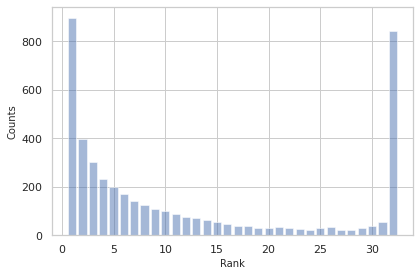

In [52]:
%autoreload
thresh=0.1
nbins=32
rank = reliability.Talagrand(thresh,nbins)
#for tii in [2,3,4,5,6]:
for tii in [7,8,9,10]:
    volcat = aeval.volcat_avg_hash[tii]
    forecast = aeval.cdump_hash[tii]
    dfin = rank.add_data_xra(volcat,forecast)
rank.plotrank()

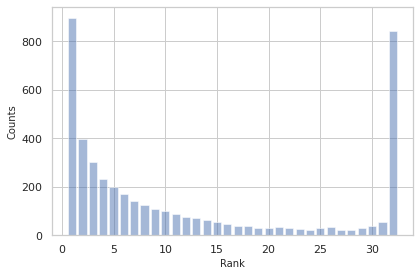

In [53]:
rank.plotrank()

In [162]:
forecast[0]

<xarray.DataArray (ens: 31, y: 34, x: 39)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * y          (y) int64 433 434 435 436 437 438 439 ... 461 462 463 464 465 466
  * x          (x) int64 877 878 879 880 881 882 883 ... 910 911 912 913 914 915
    longitude  (y, x) float64 158.2 158.3 158.4 158.5 ... 161.8 161.9 162.0
    latitude   (y, x) float64 54.18 54.18 54.18 54.18 ... 57.48 57.48 57.48
    source     <U2 'M4'
    time       datetime64[ns] 2020-10-21T22:00:00
  * ens        (ens) object 'gep01' 'gep02' 'gep03' ... 'gep29' 'gep30' 'gec00'

In [163]:
tii=8
volcat = aeval.volcat_avg_hash[tii]
forecast = aeval.cdump_hash[tii]

In [158]:
from utilhysplit.evaluation import cdf_matching

In [159]:
%autoreload

In [176]:
rfc = forecast.isel(ens=1).values.flatten()
robs = volcat.values.flatten()

In [177]:
print(len(rfc))
print(len(robs))

6674
6674


In [193]:
rfc = np.array([0,1,2,3,4])
robs = 2*rfc + 1

rfit = cdf_matching.apply_polyfit(rfc,robs)

[2. 1.]


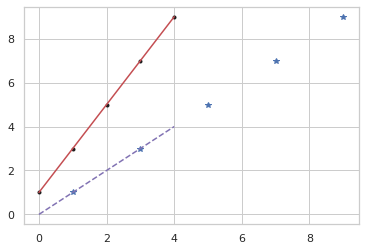

In [197]:
plt.plot(rfc,robs,'k.')
x = np.array([0,1,2,3,4])
y = rfit[0]*x + rfit[1]
plt.plot(x,y,'-r')
print(rfit)
plt.plot(rfc*rfit[0]+rfit[1],robs, 'b*')
plt.plot(x,x,'--m')